In [36]:
import pandas as pd
import seaborn as sns
data_prep=pd.read_csv('train.csv')
data_copy=data_prep.copy()
data=data_prep.drop(['SalePrice'],axis=1)
data_y=data_prep[['SalePrice']]

C:\Users\Sophie\AppData\Local\Temp\ipykernel_20012\2126899542.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,10))
C:\Users\Sophie\AppData\Local\Temp\ipykernel_20012\2126899542.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_numeric[i]=current_year-data_numeric[i]
C:\Users\Sophie\AppData\Local\Temp\ipykernel_20012\2126899542.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

Mean squared error: 746384557.4310918
R2 score for Xgboost training 0.9026919406984638


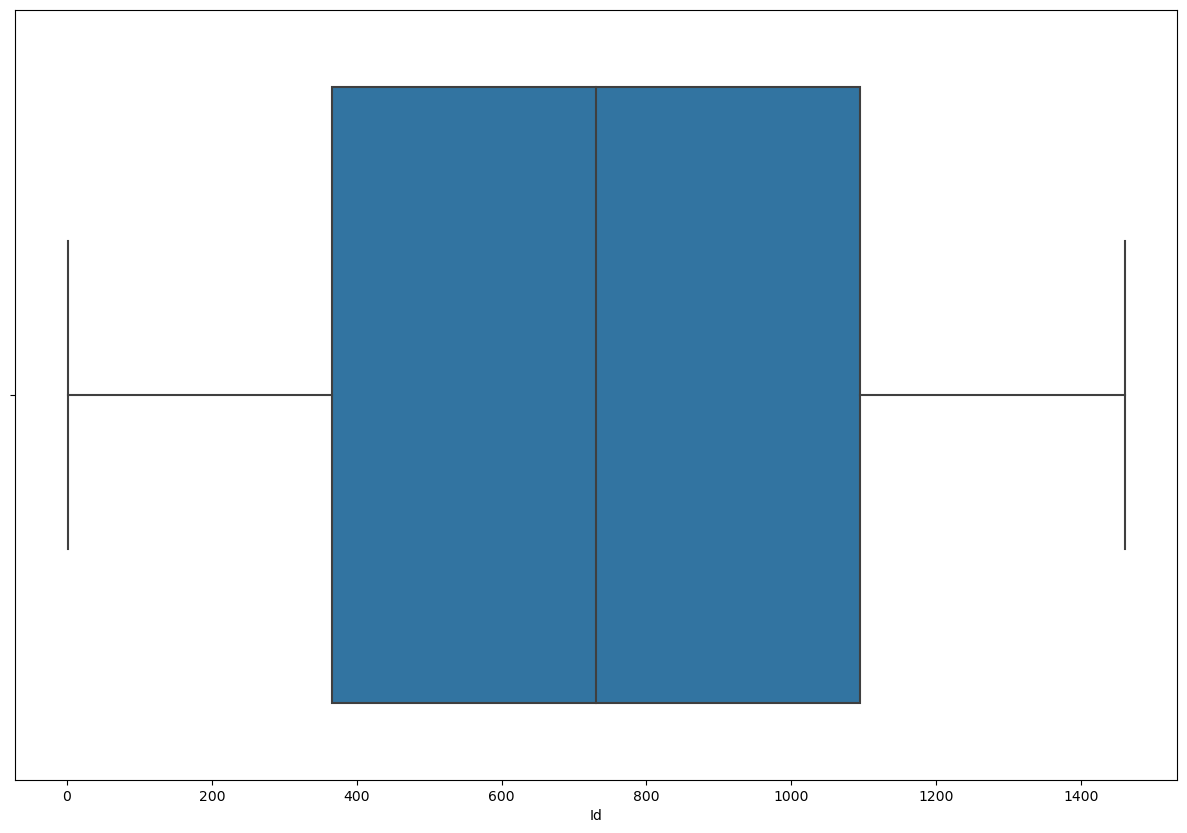

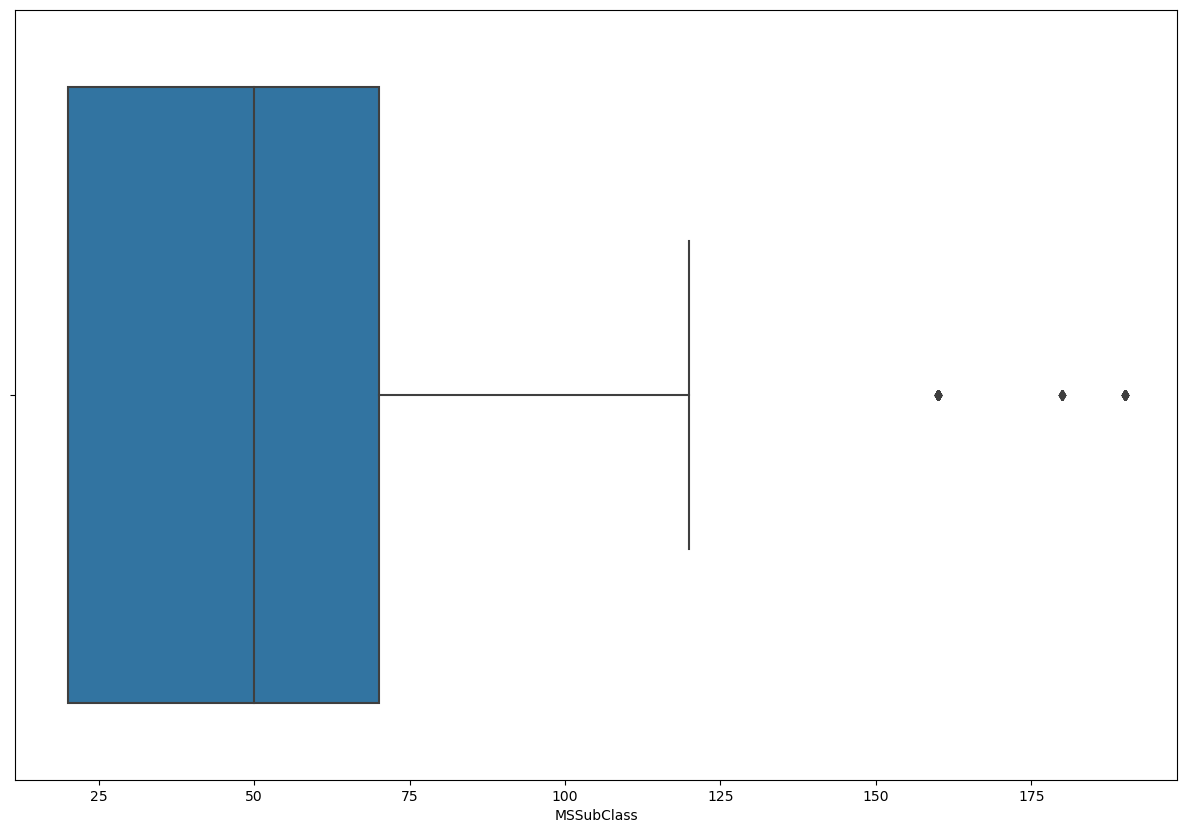

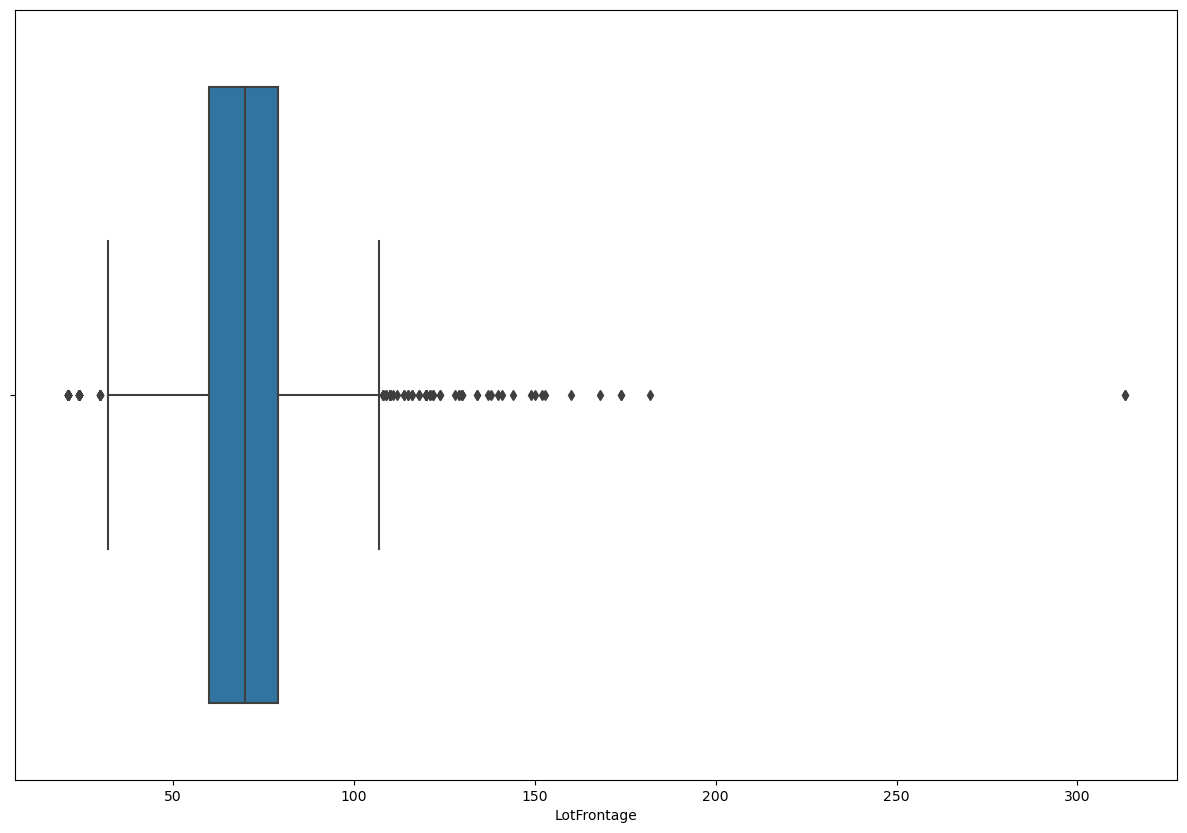

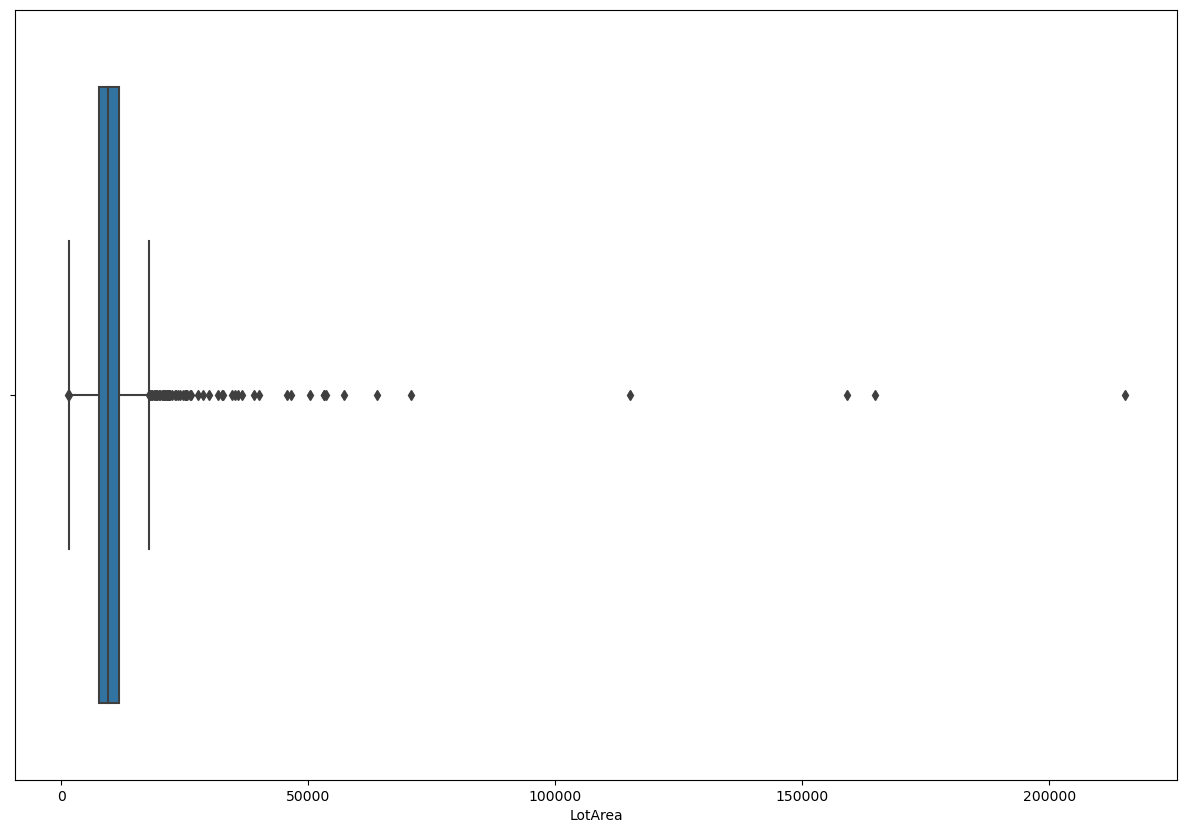

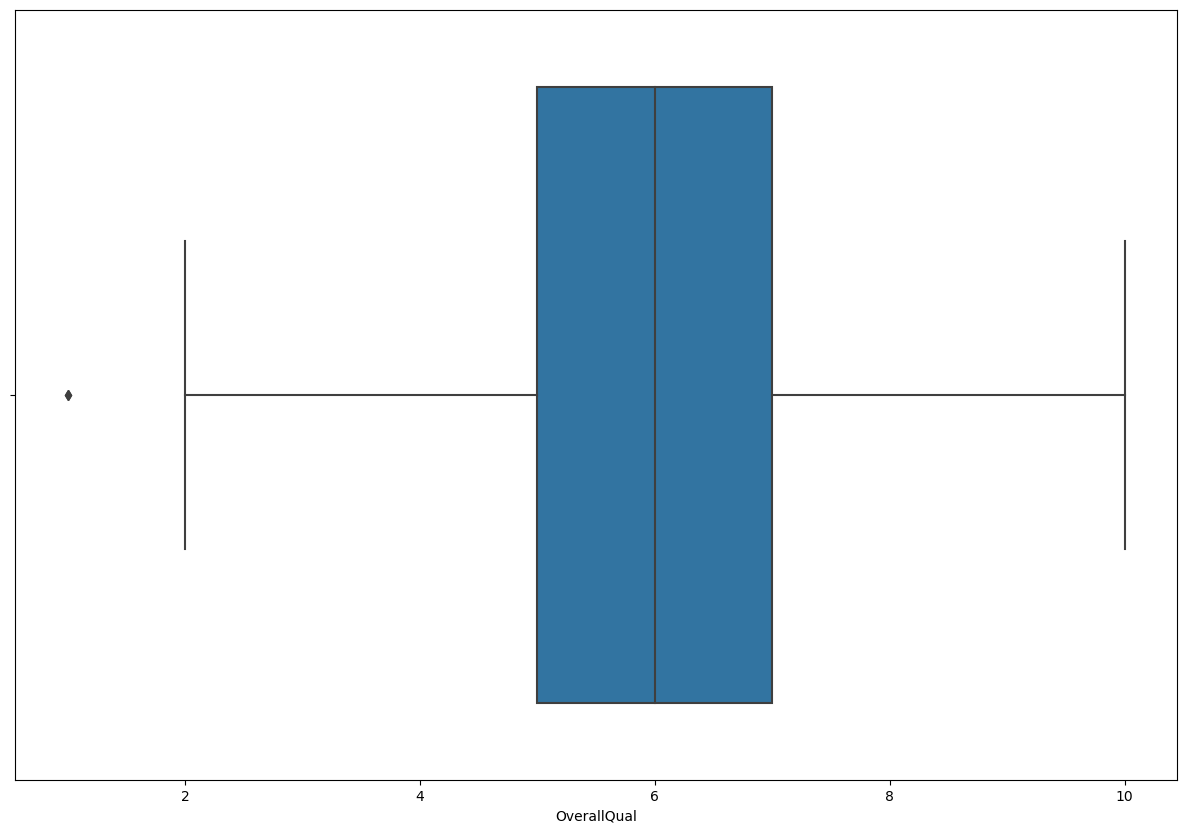

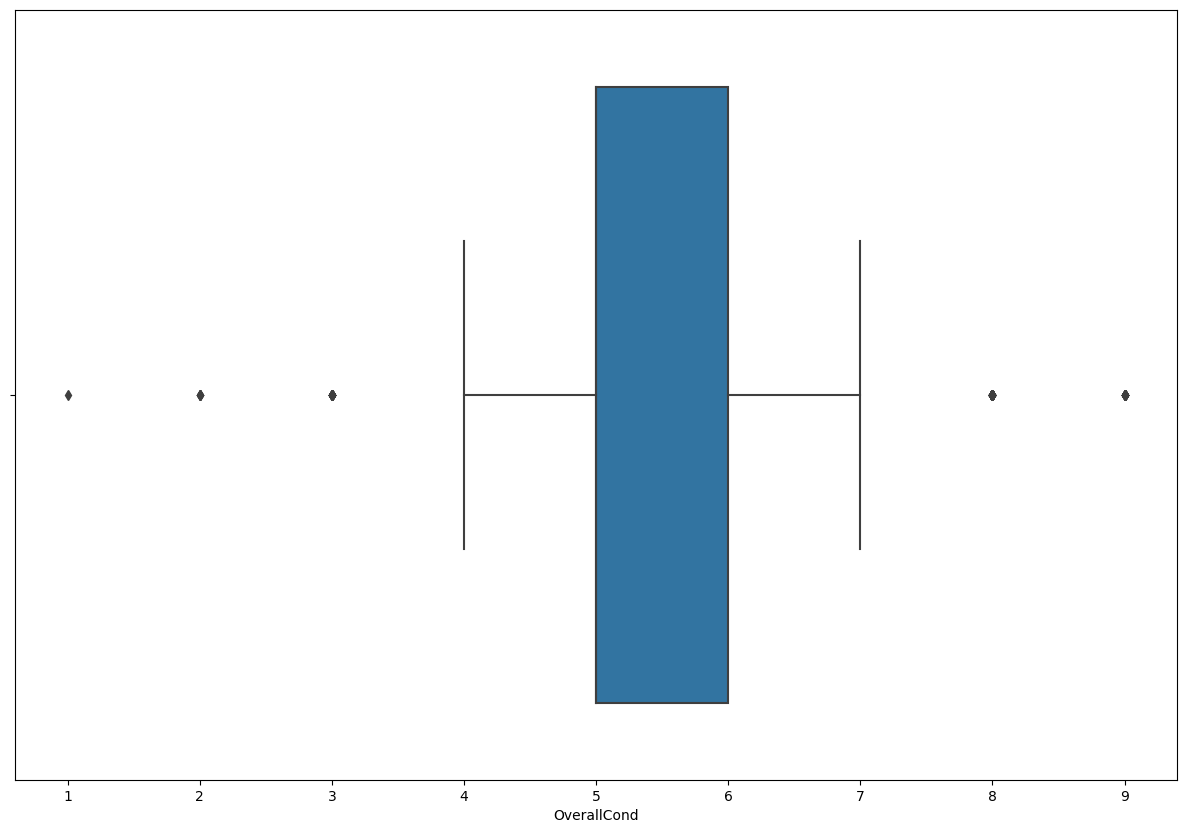

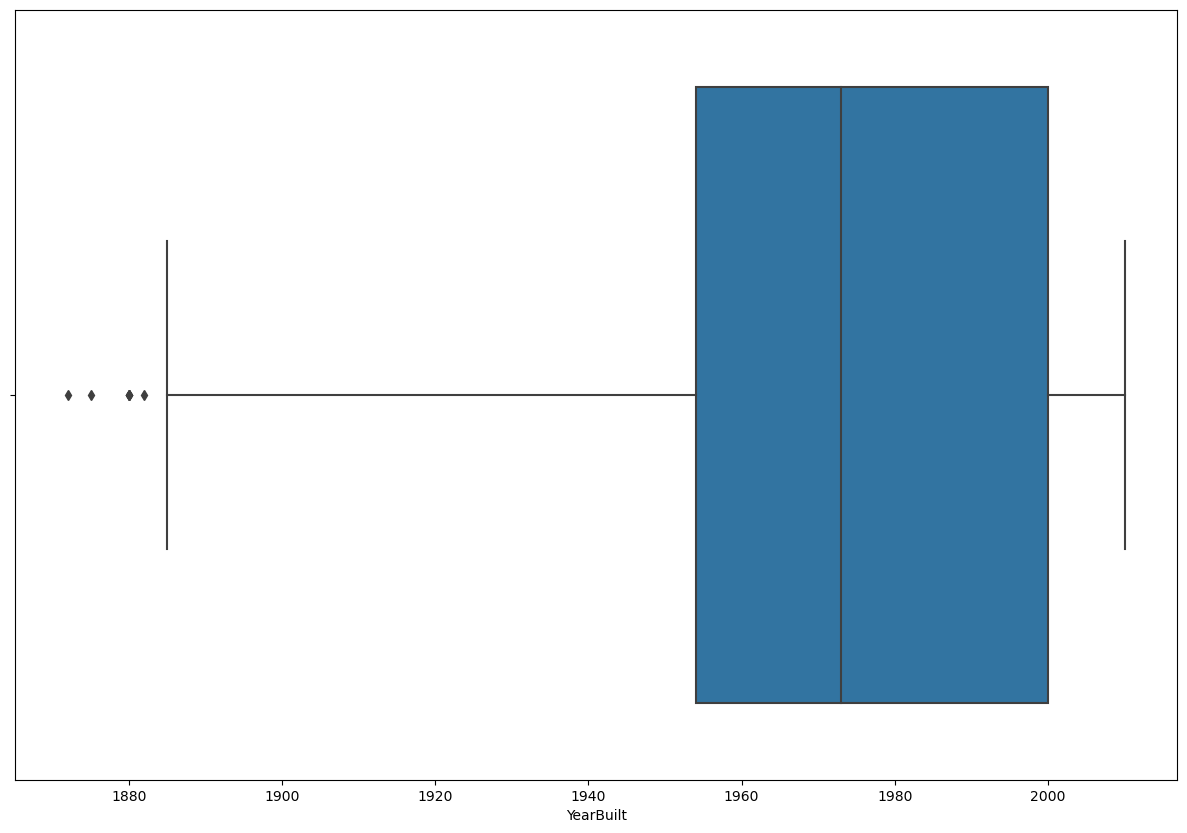

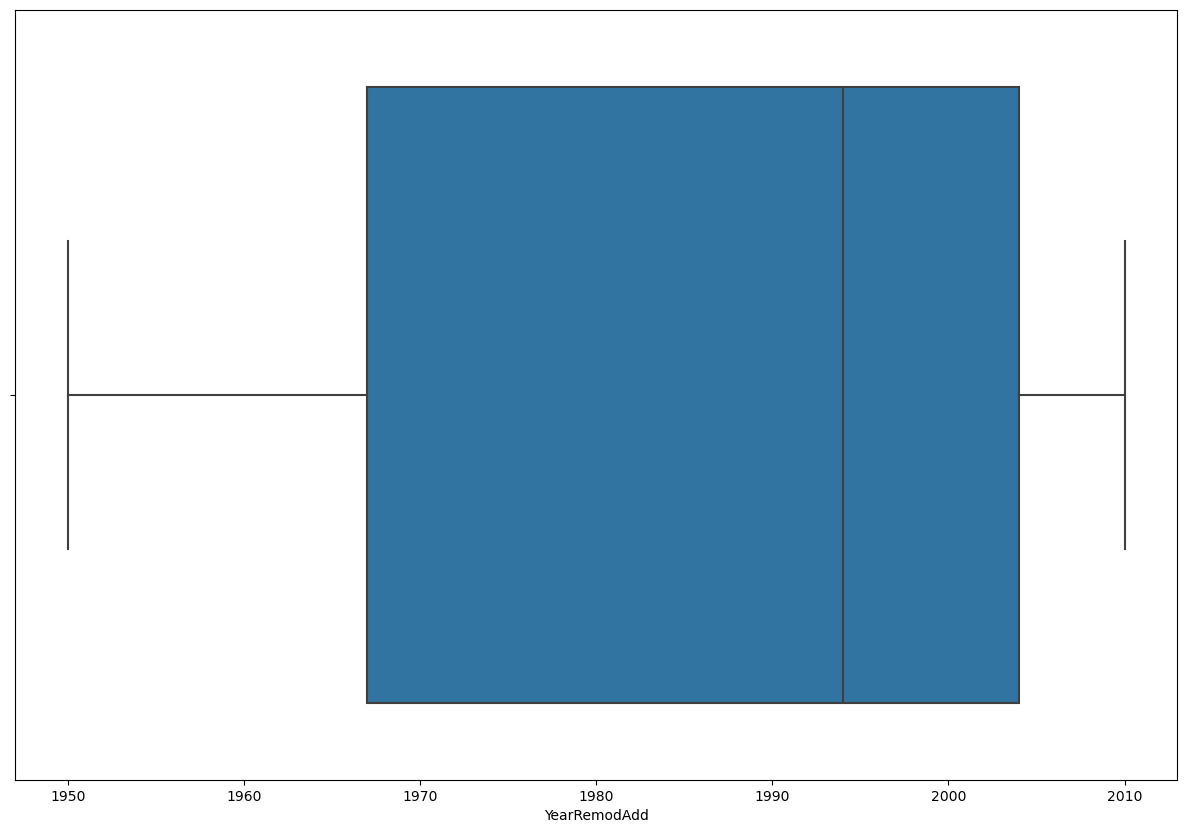

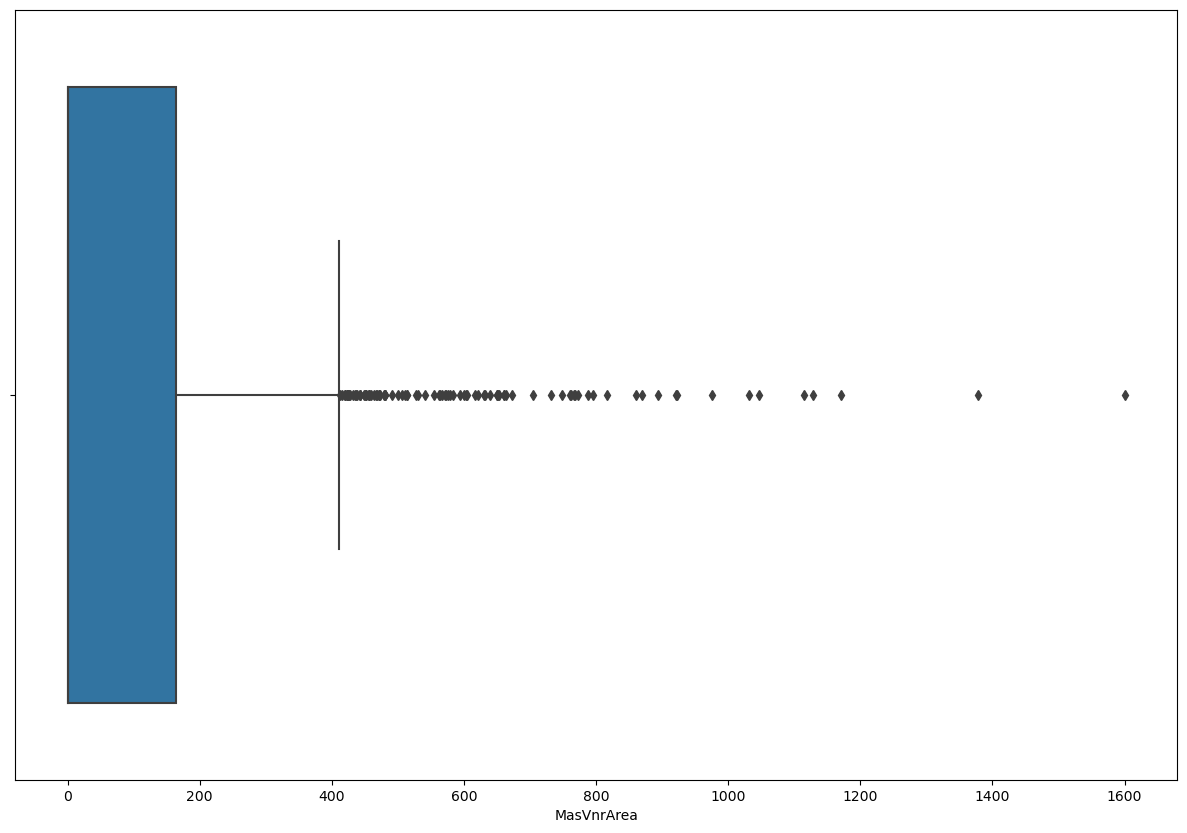

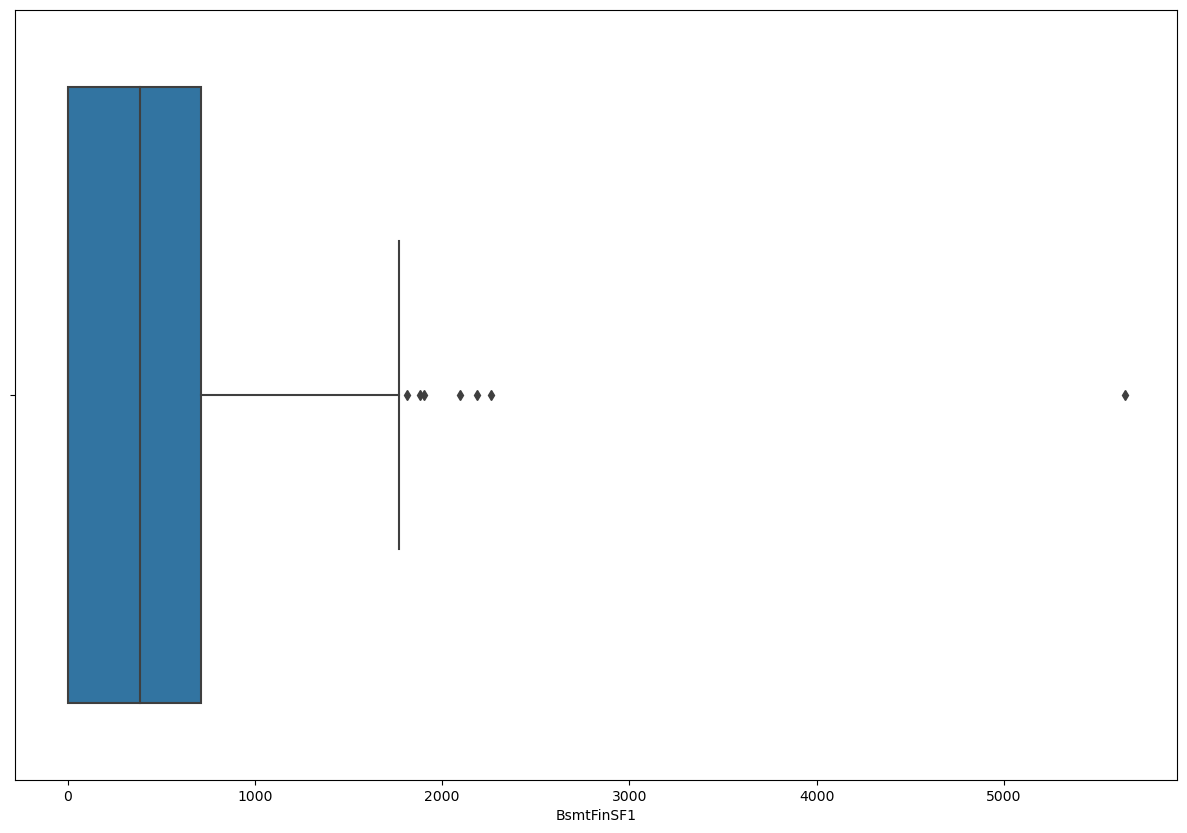

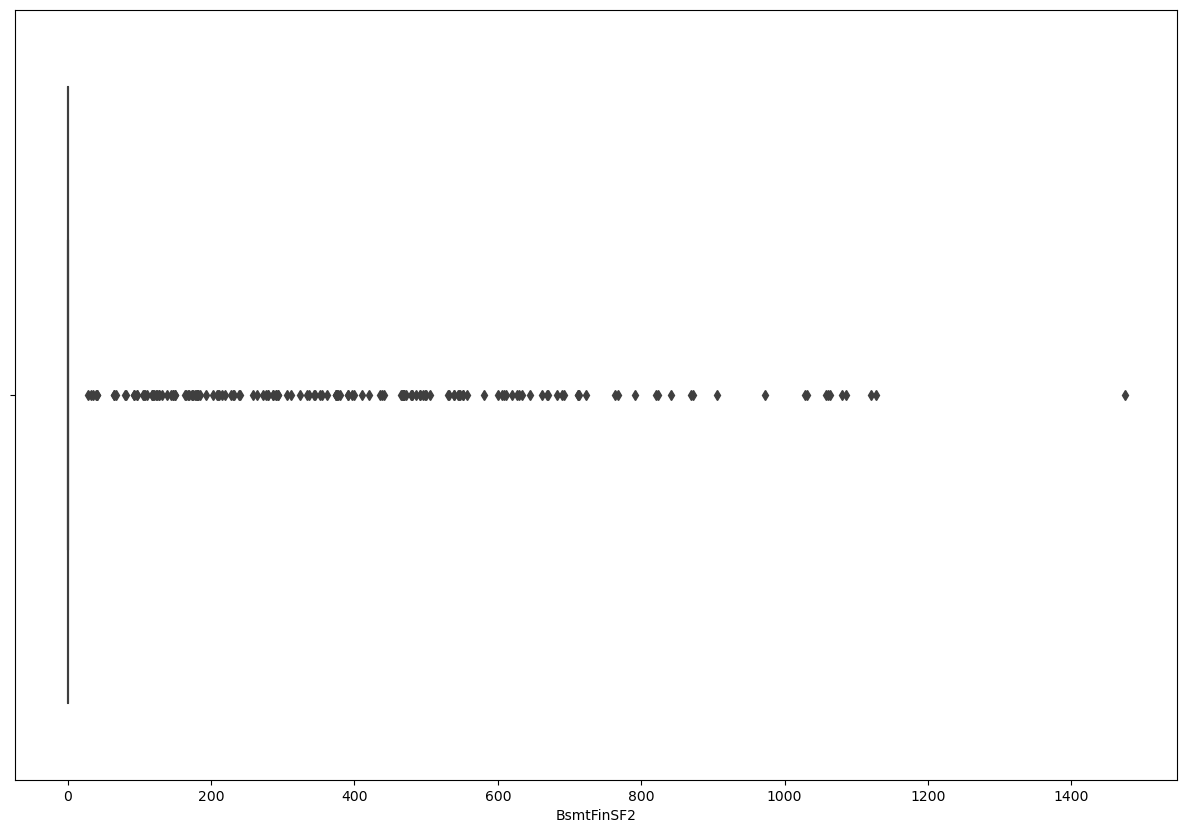

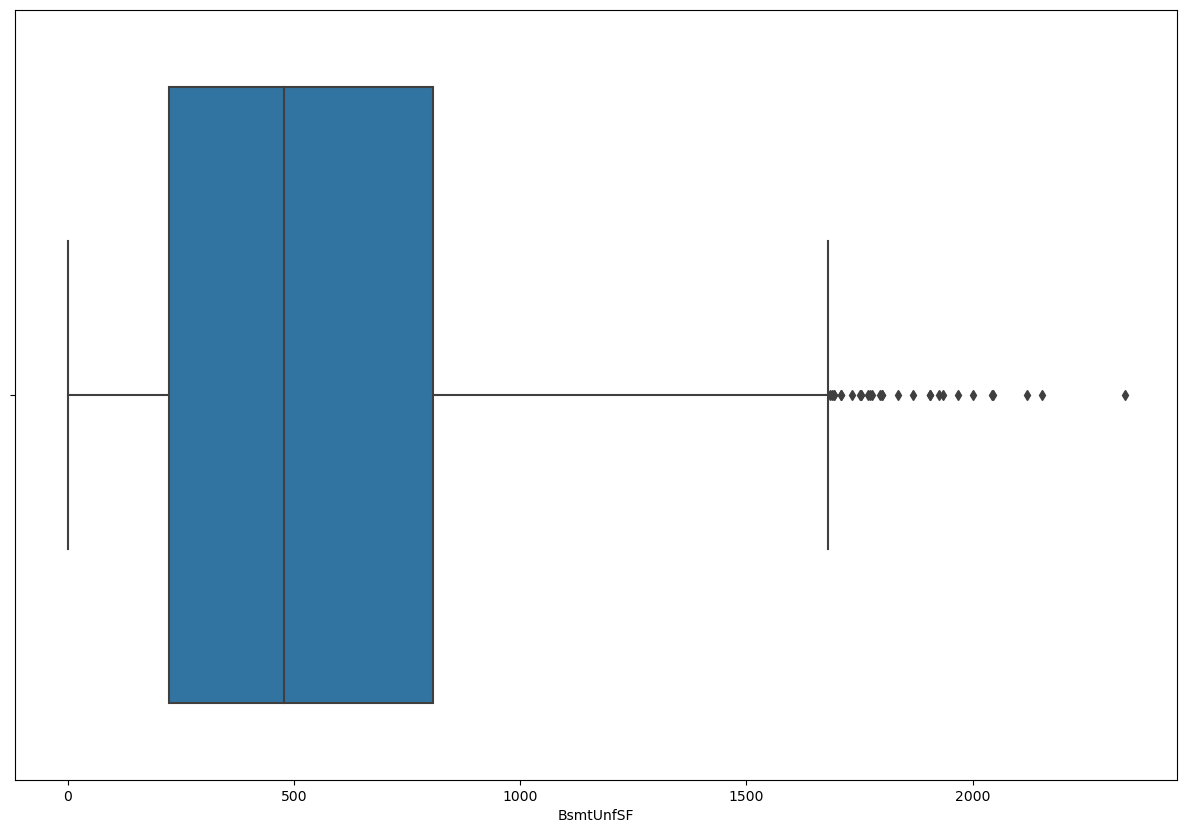

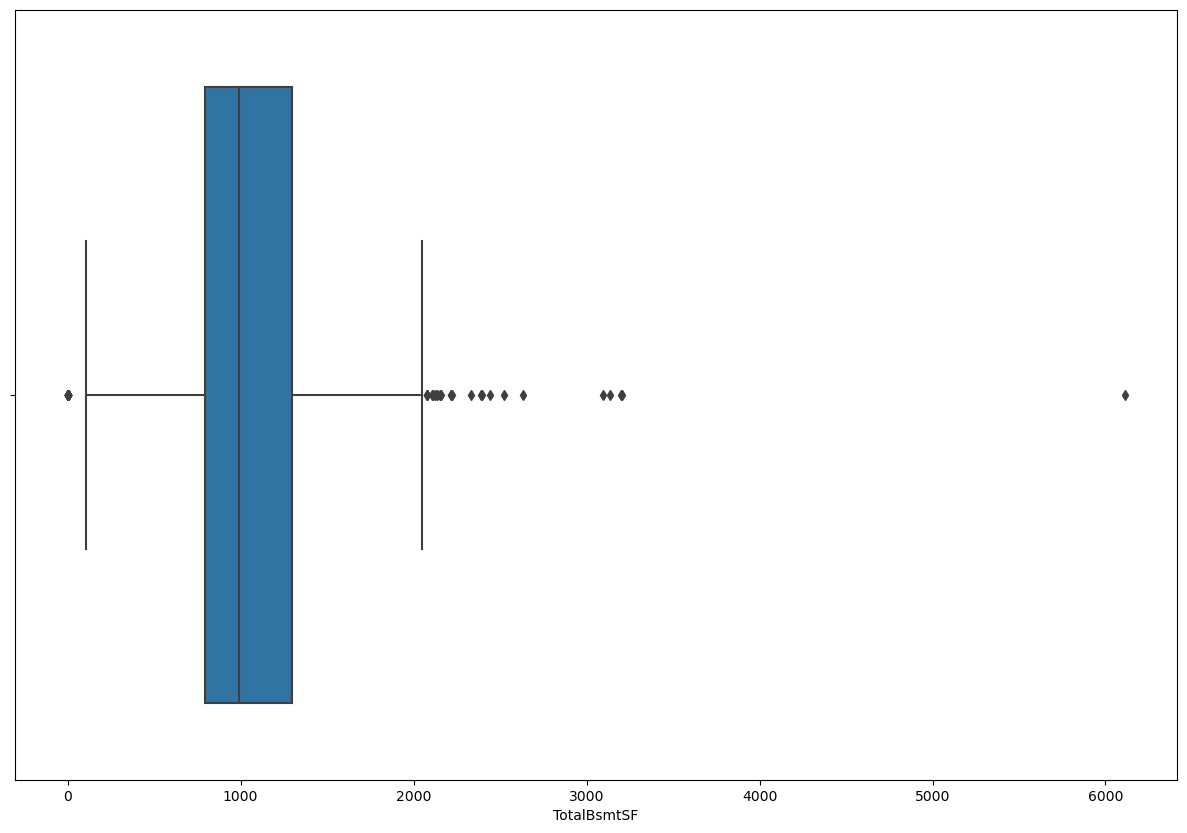

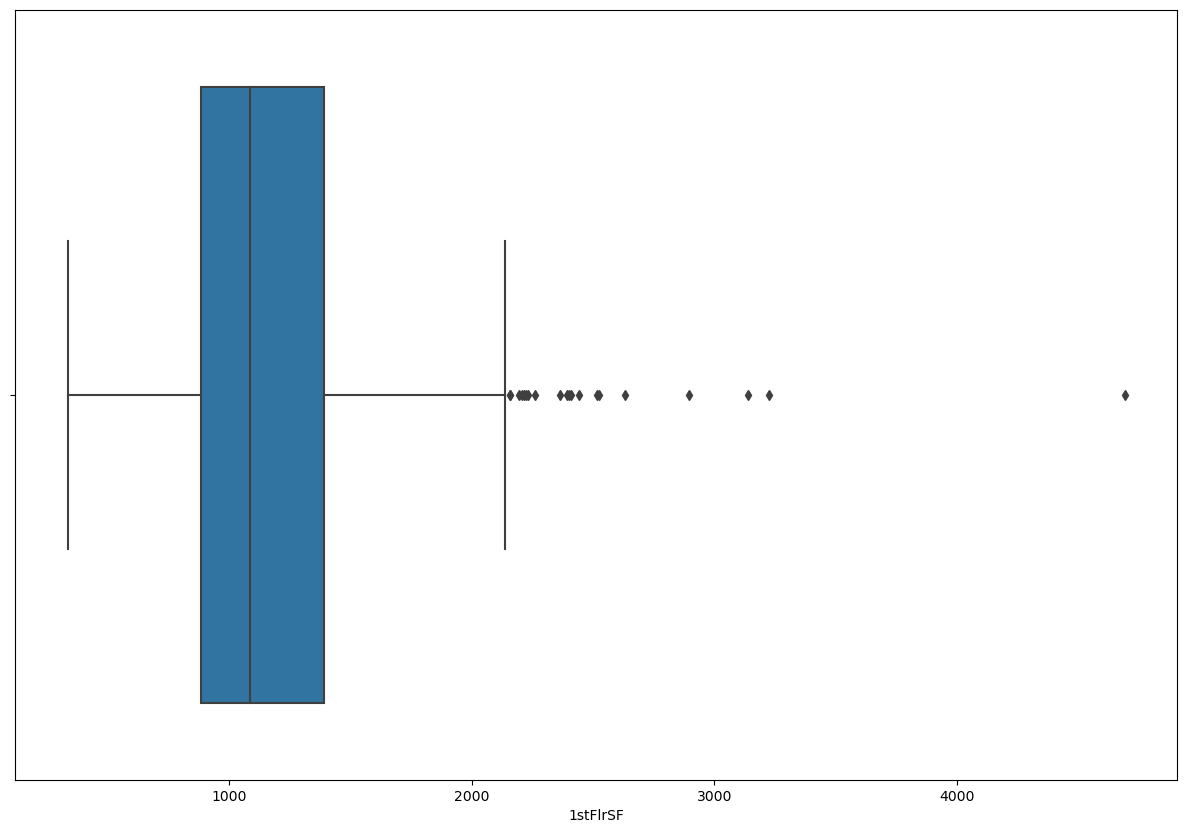

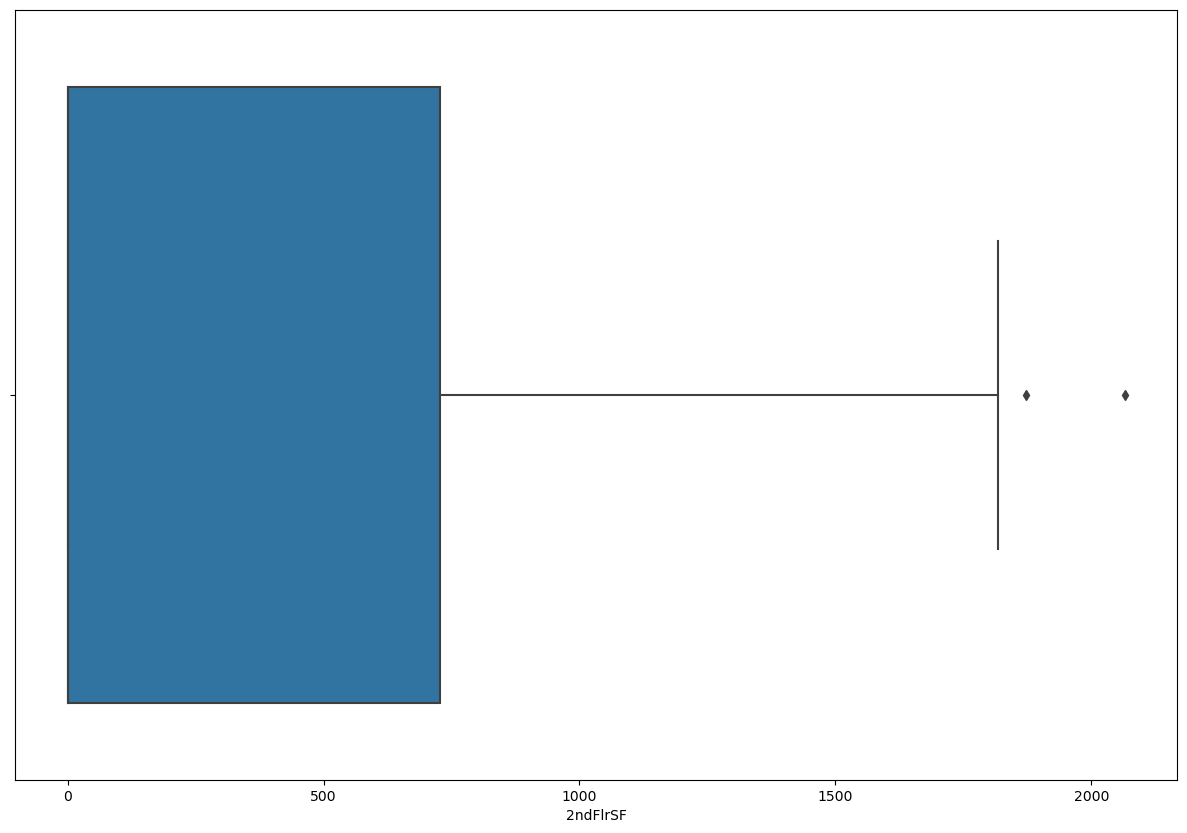

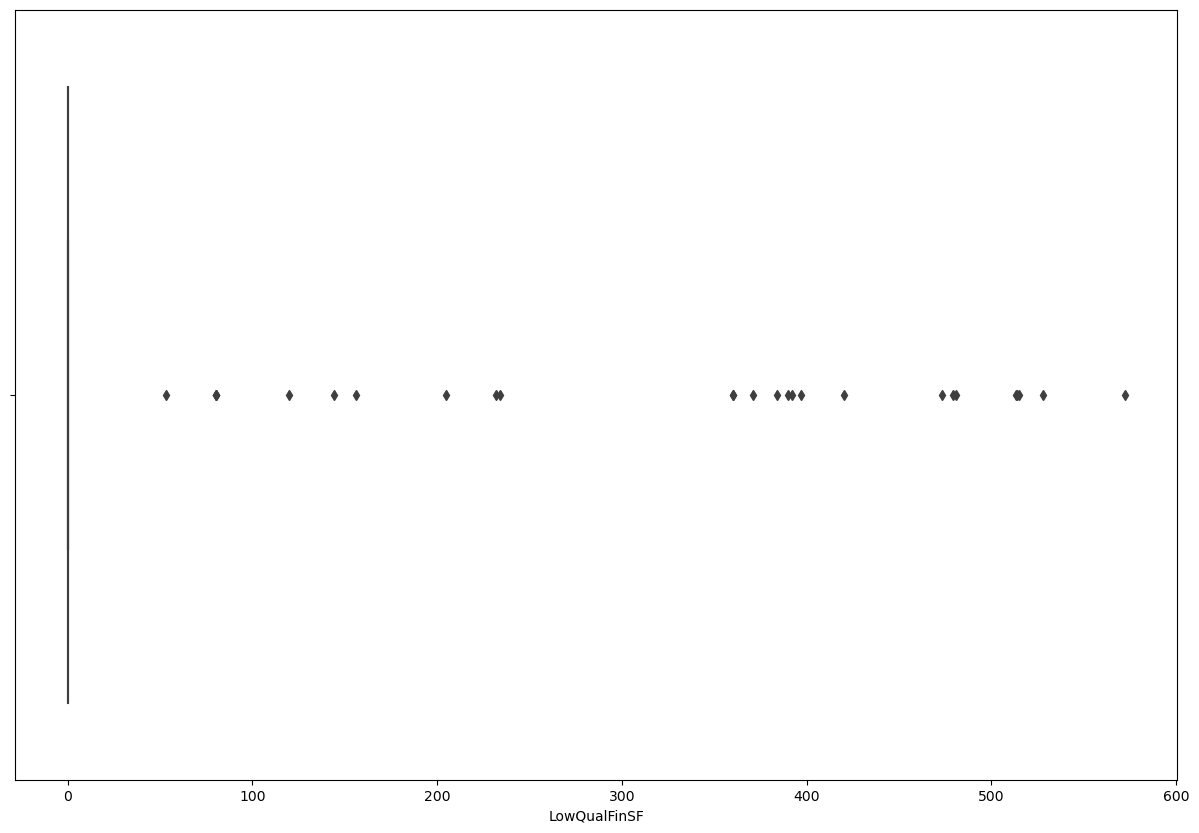

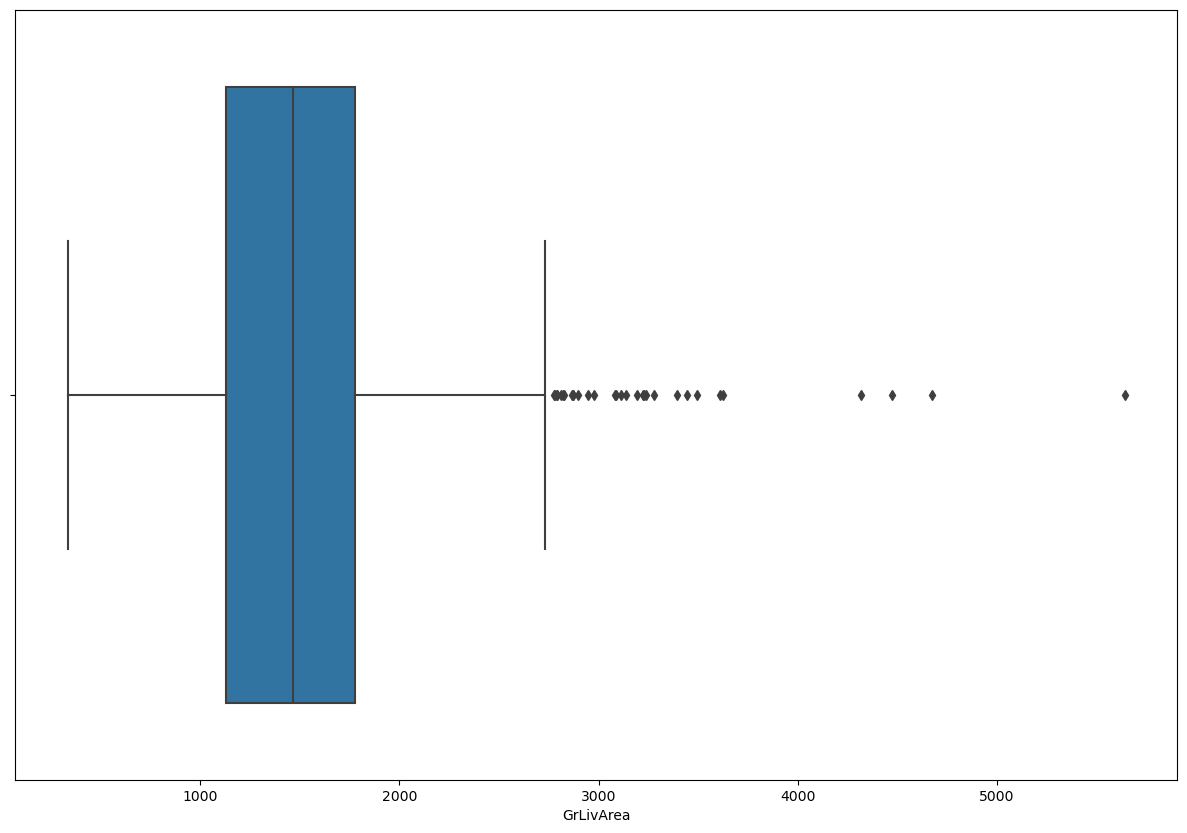

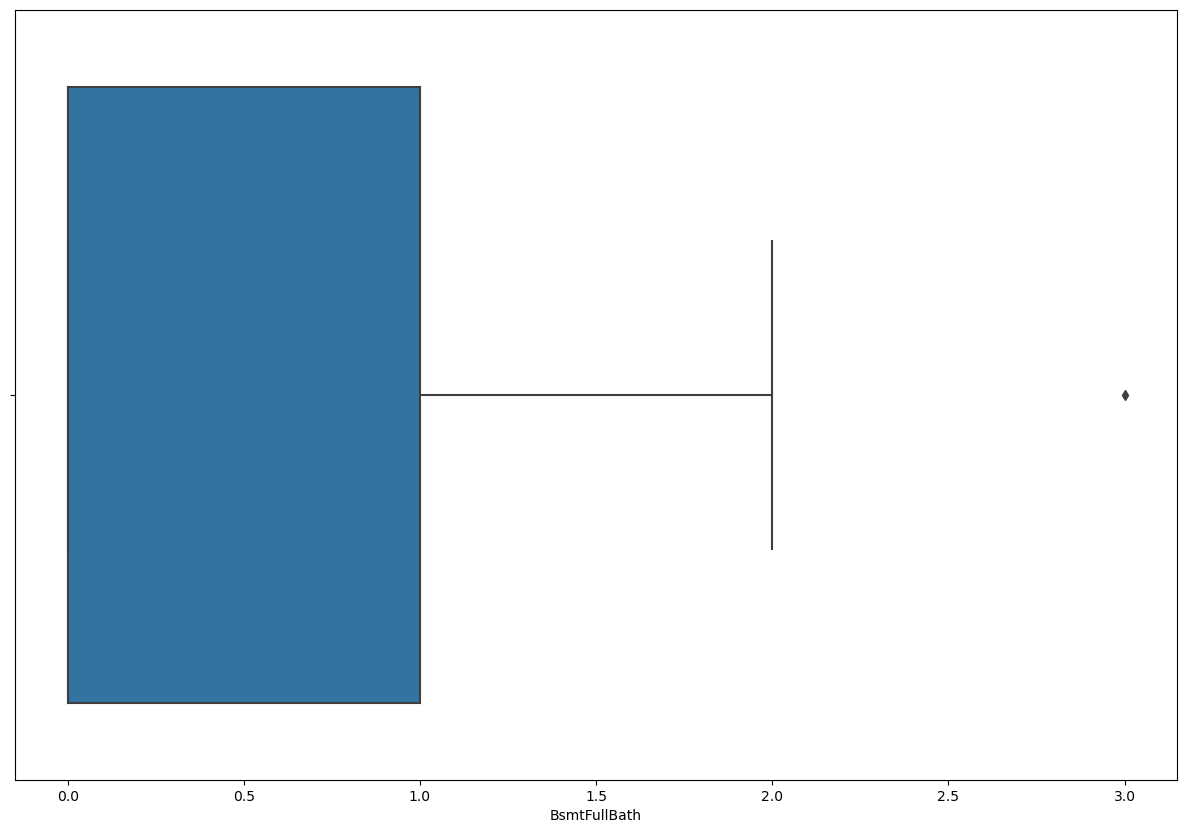

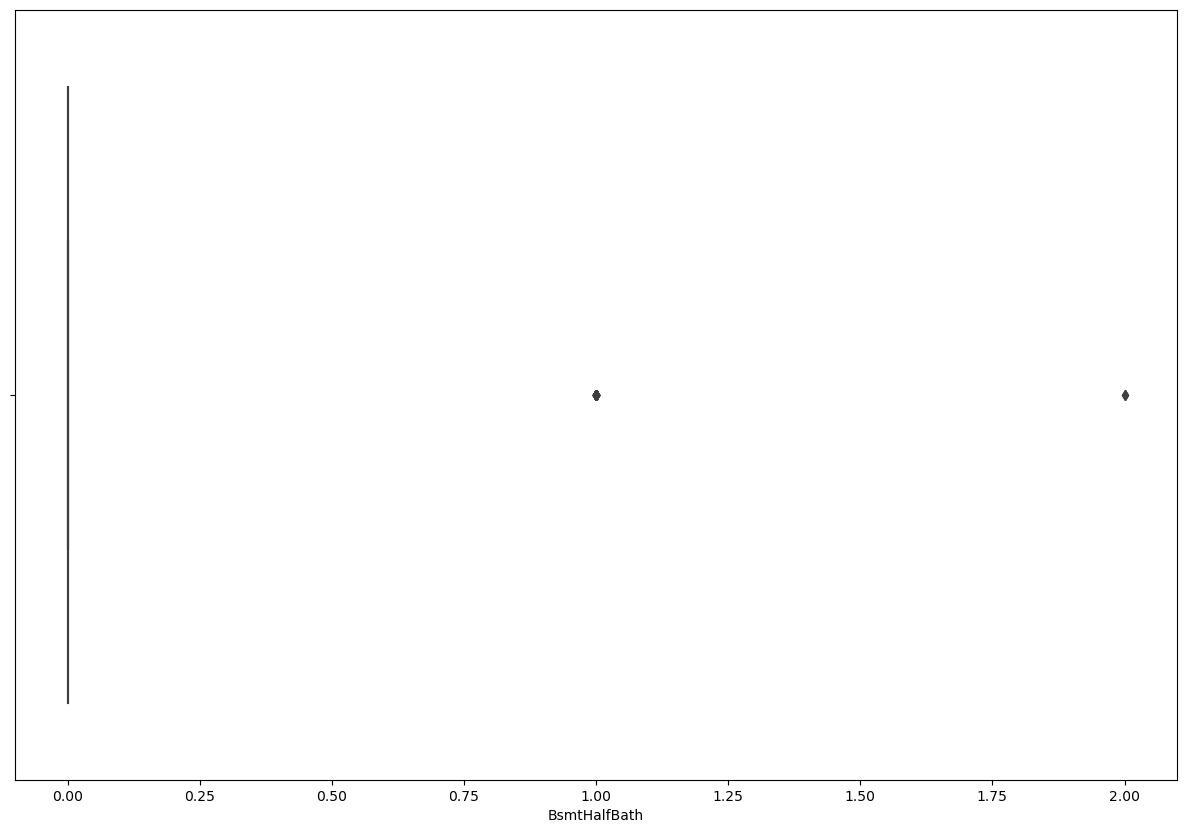

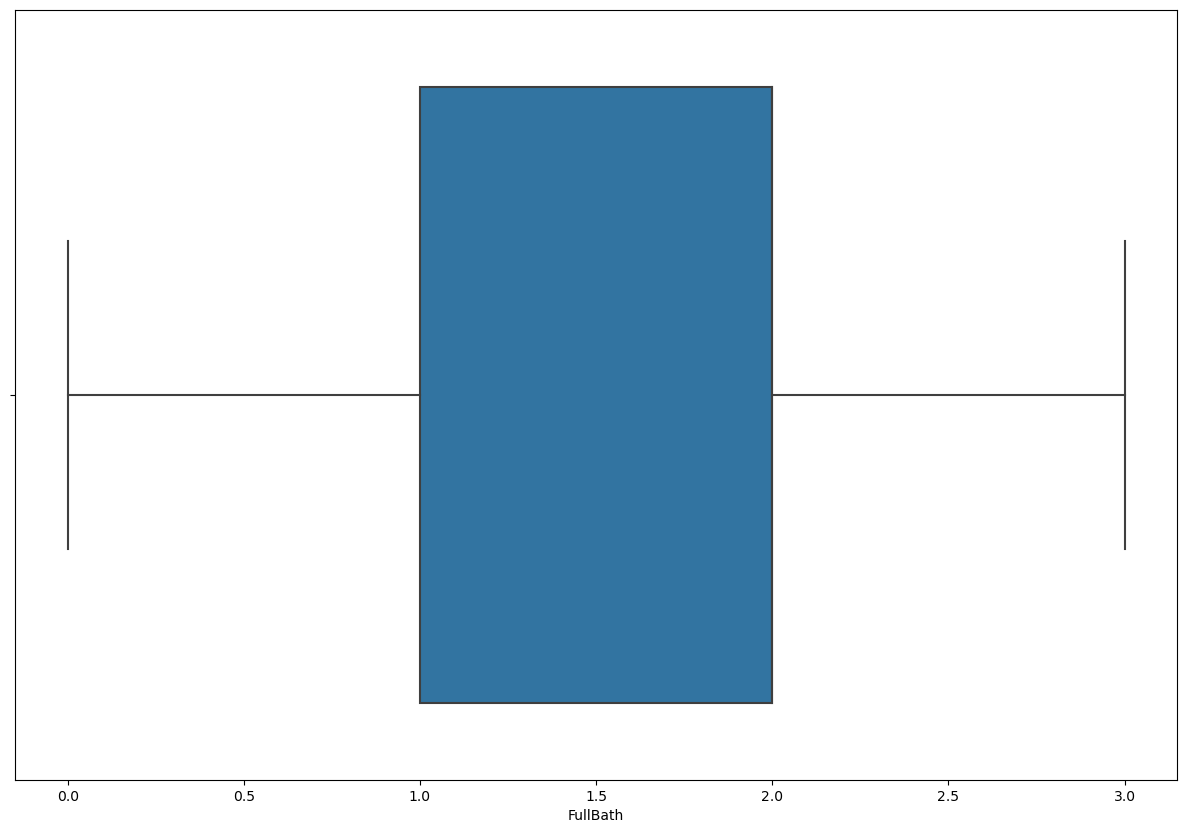

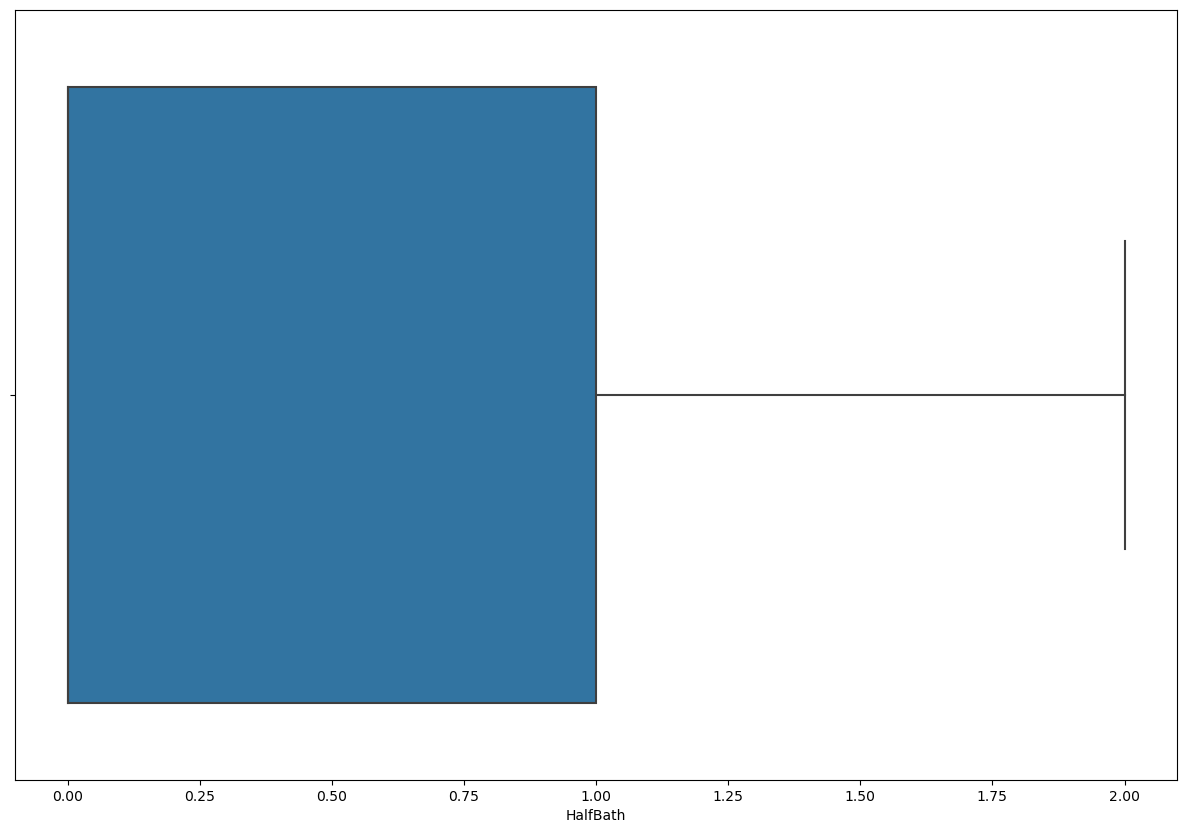

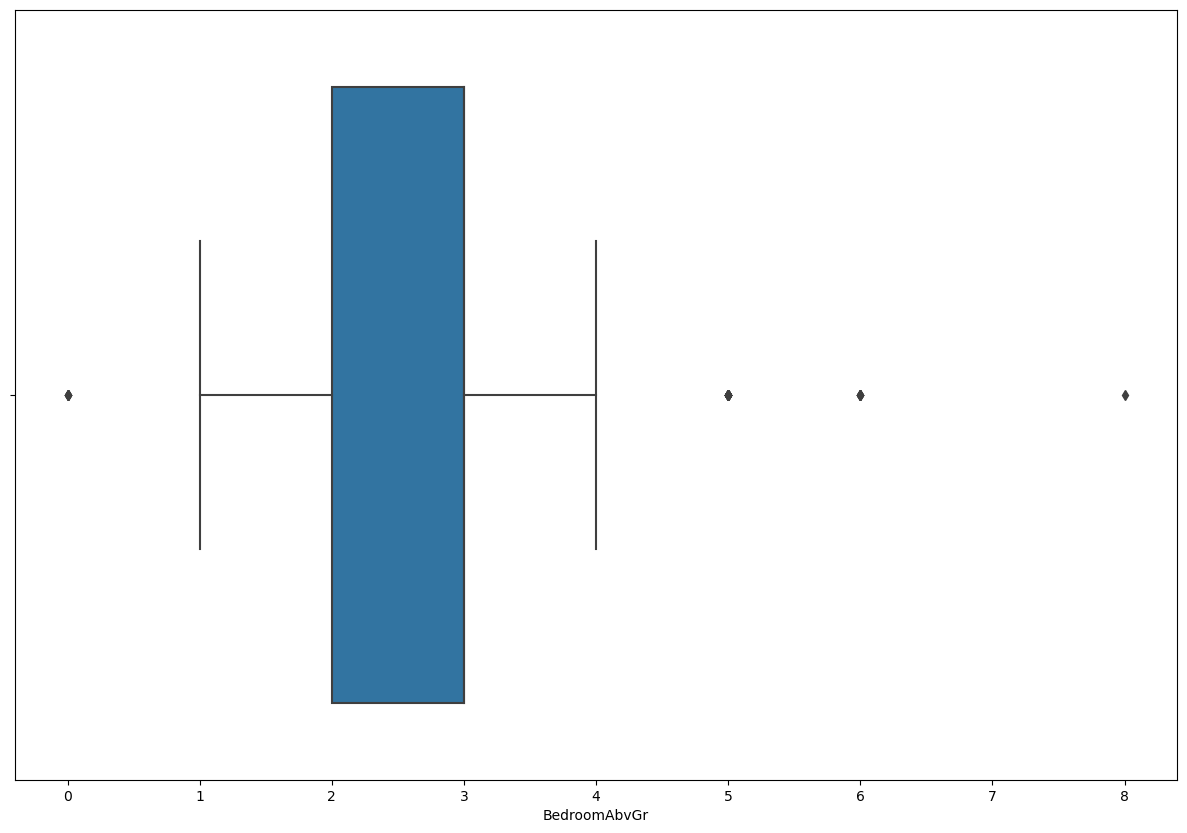

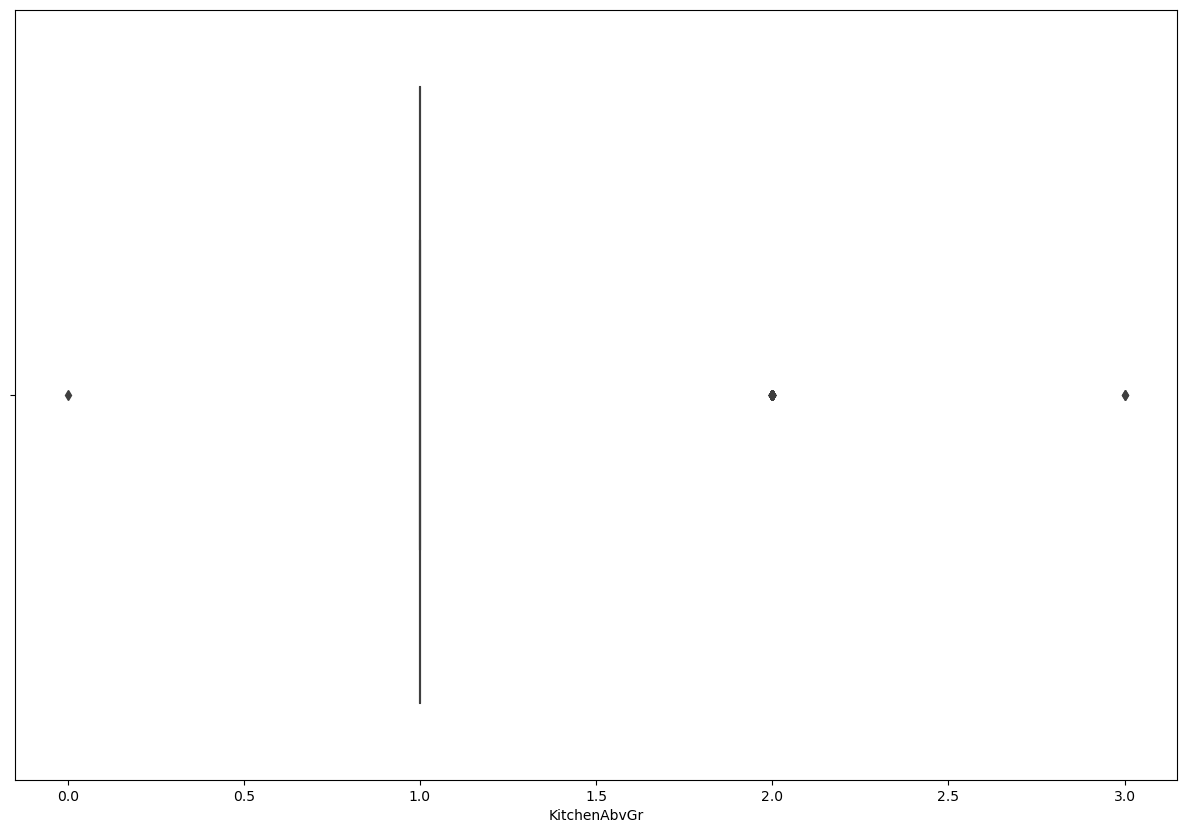

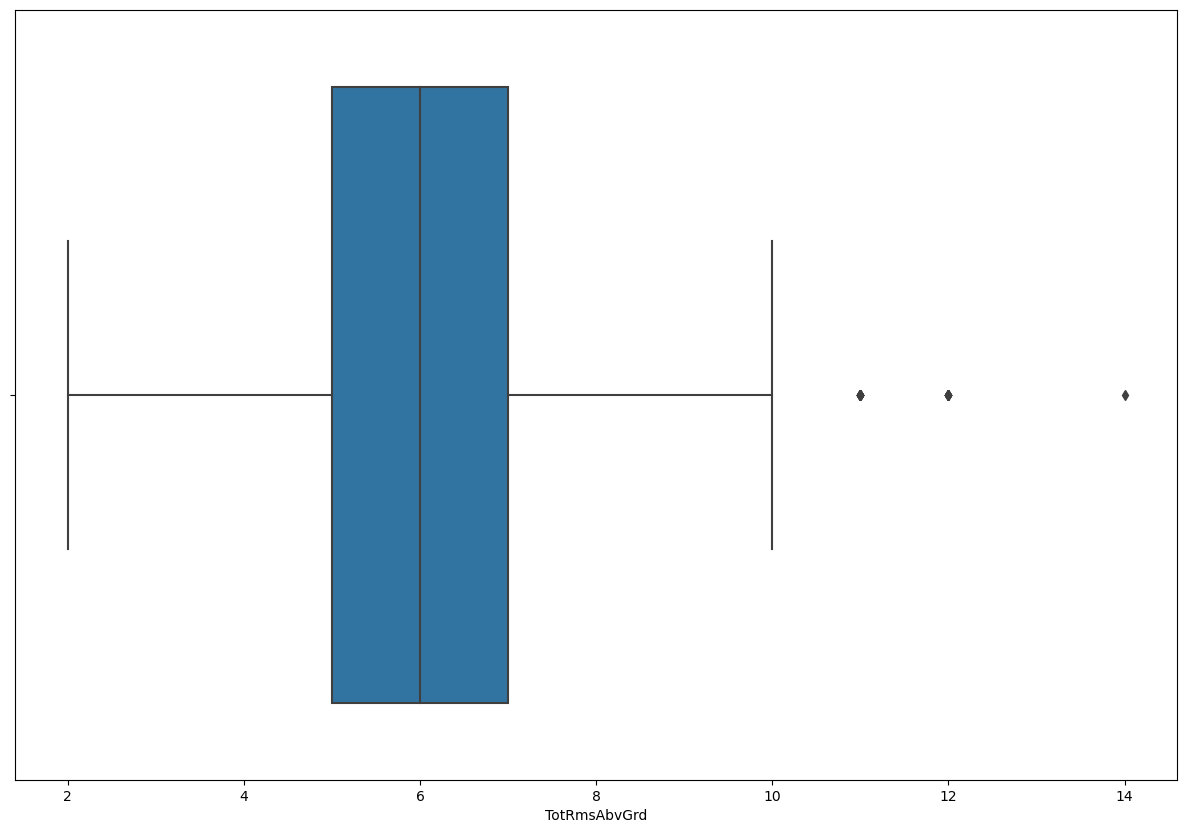

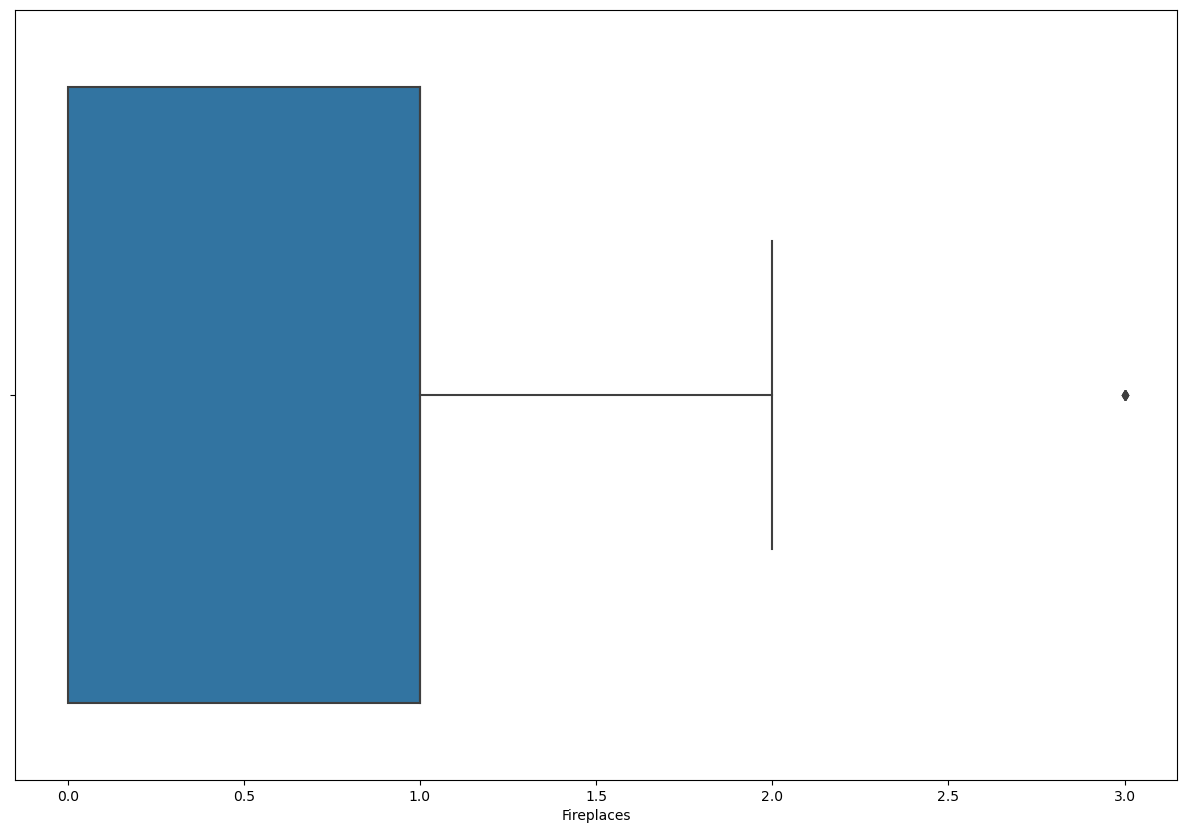

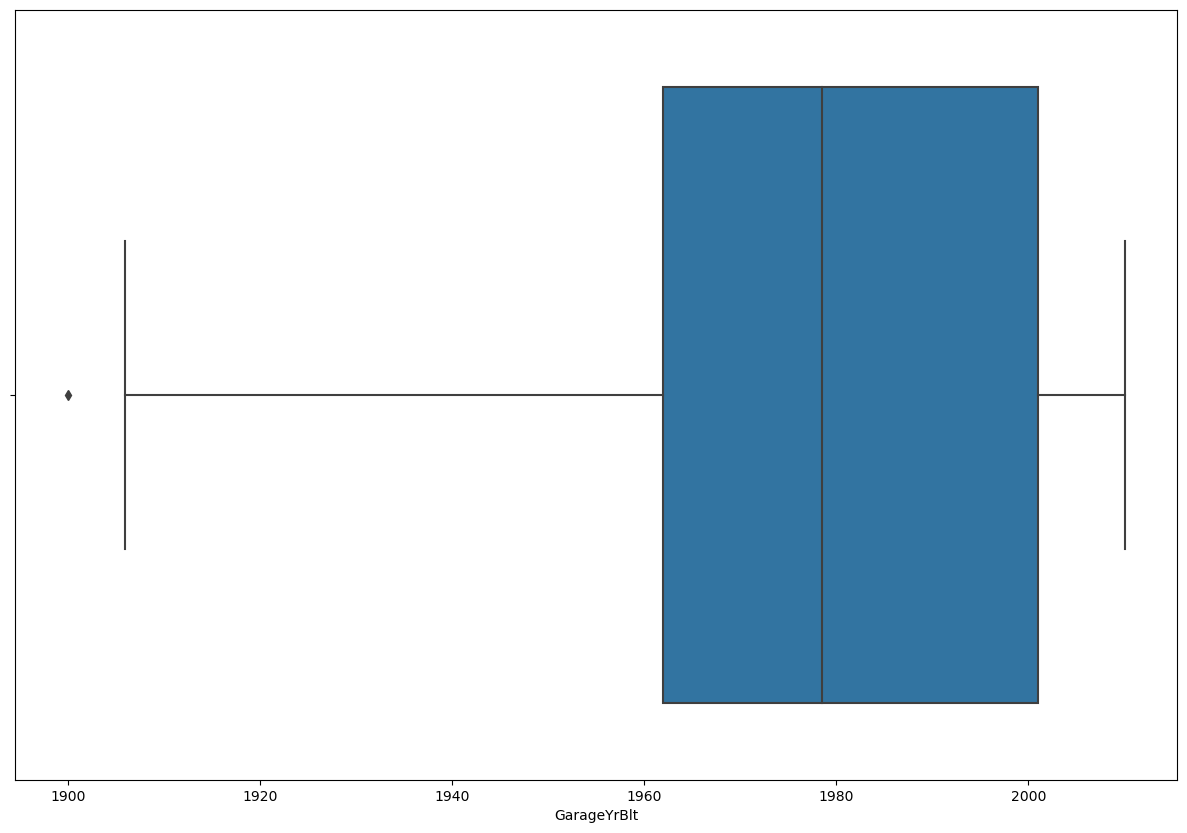

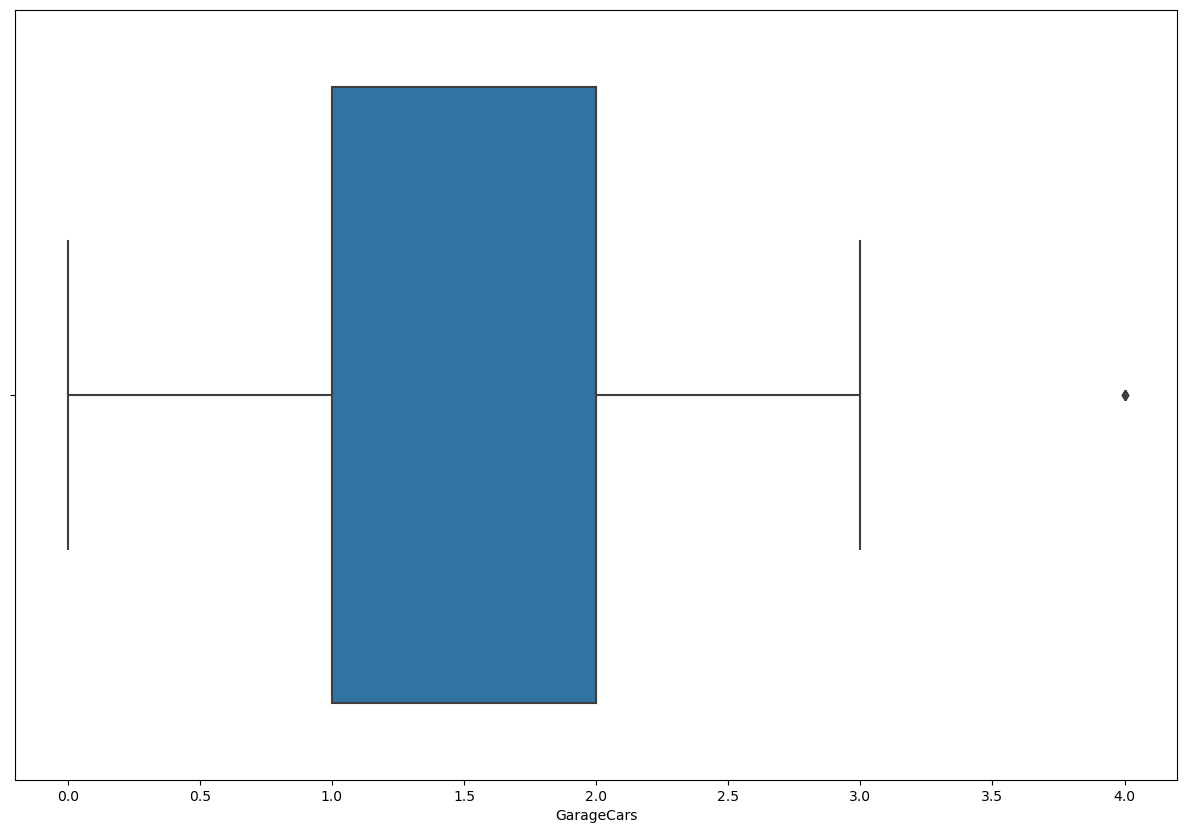

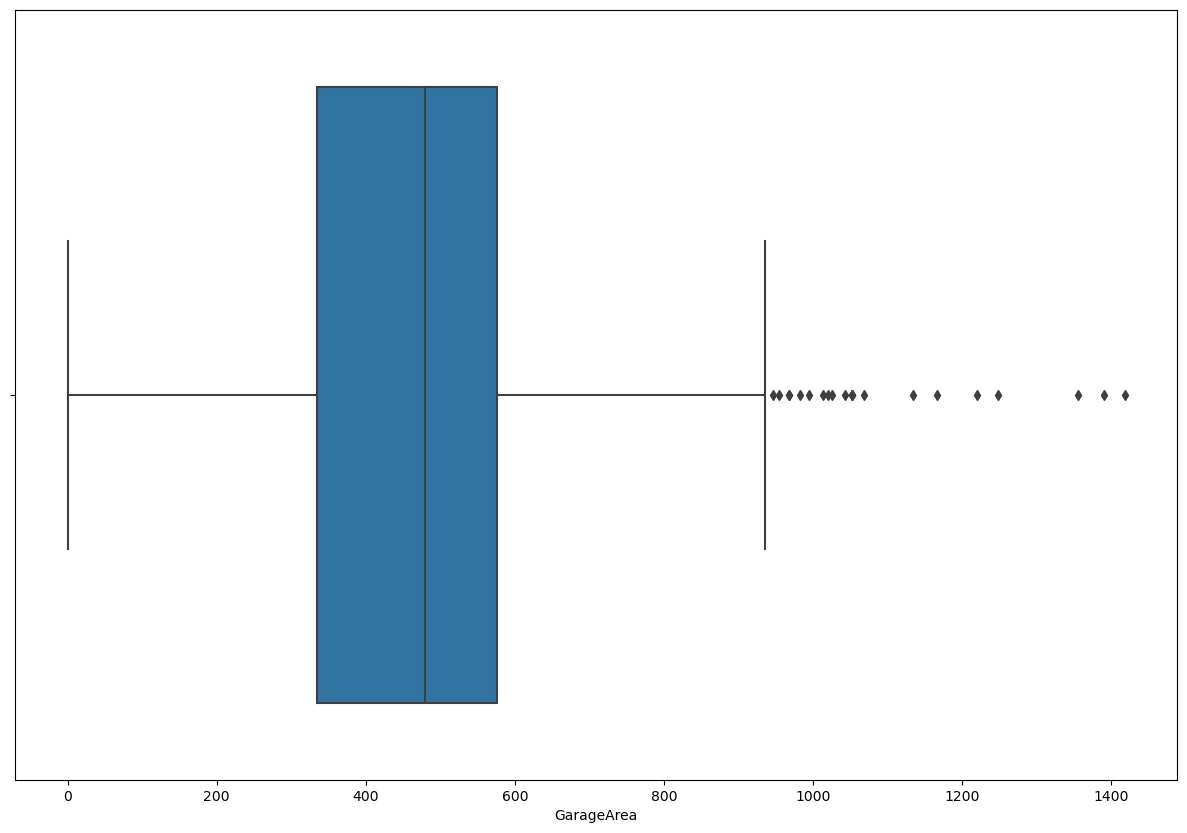

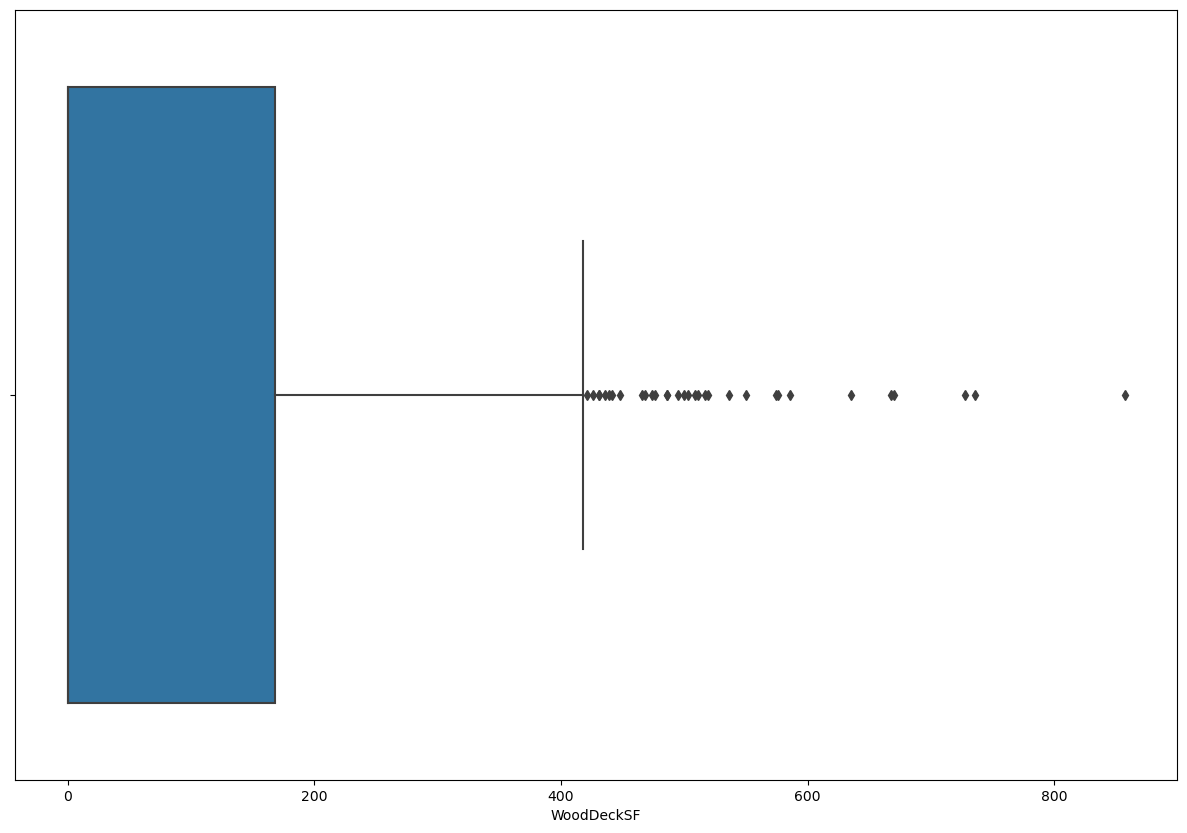

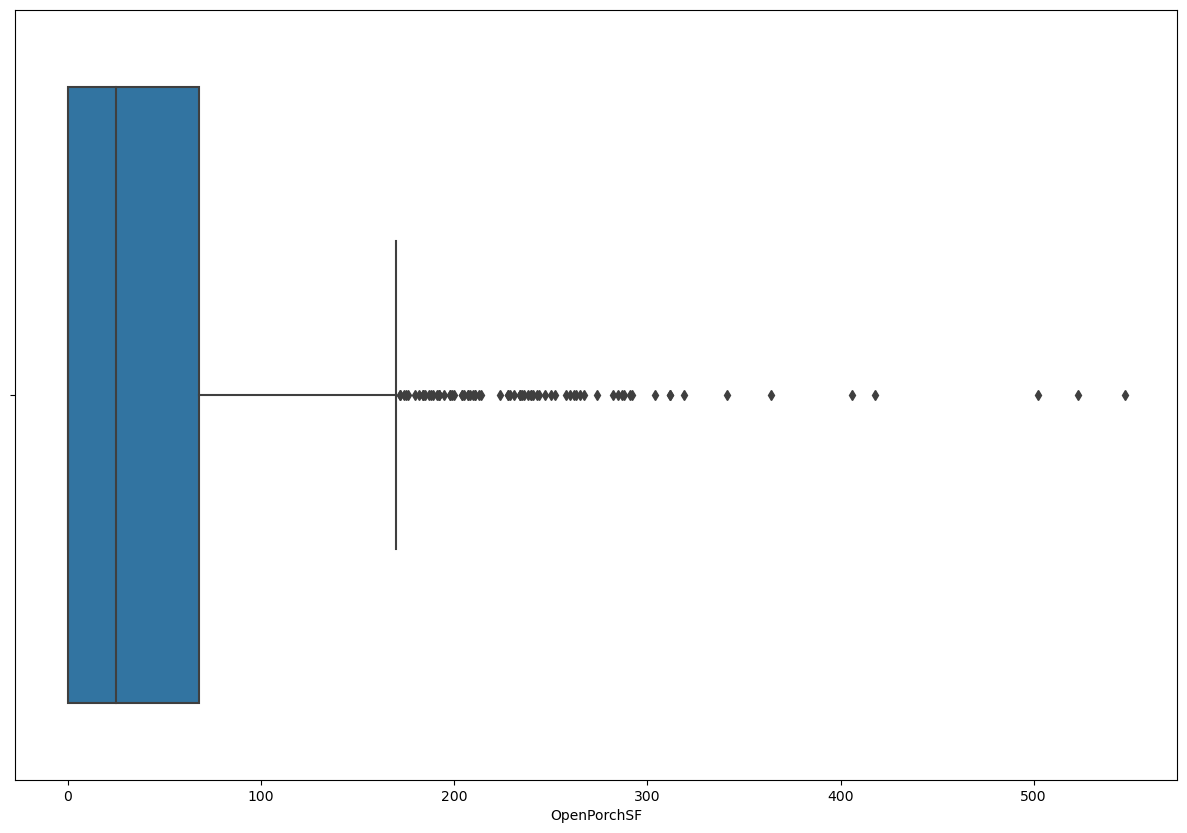

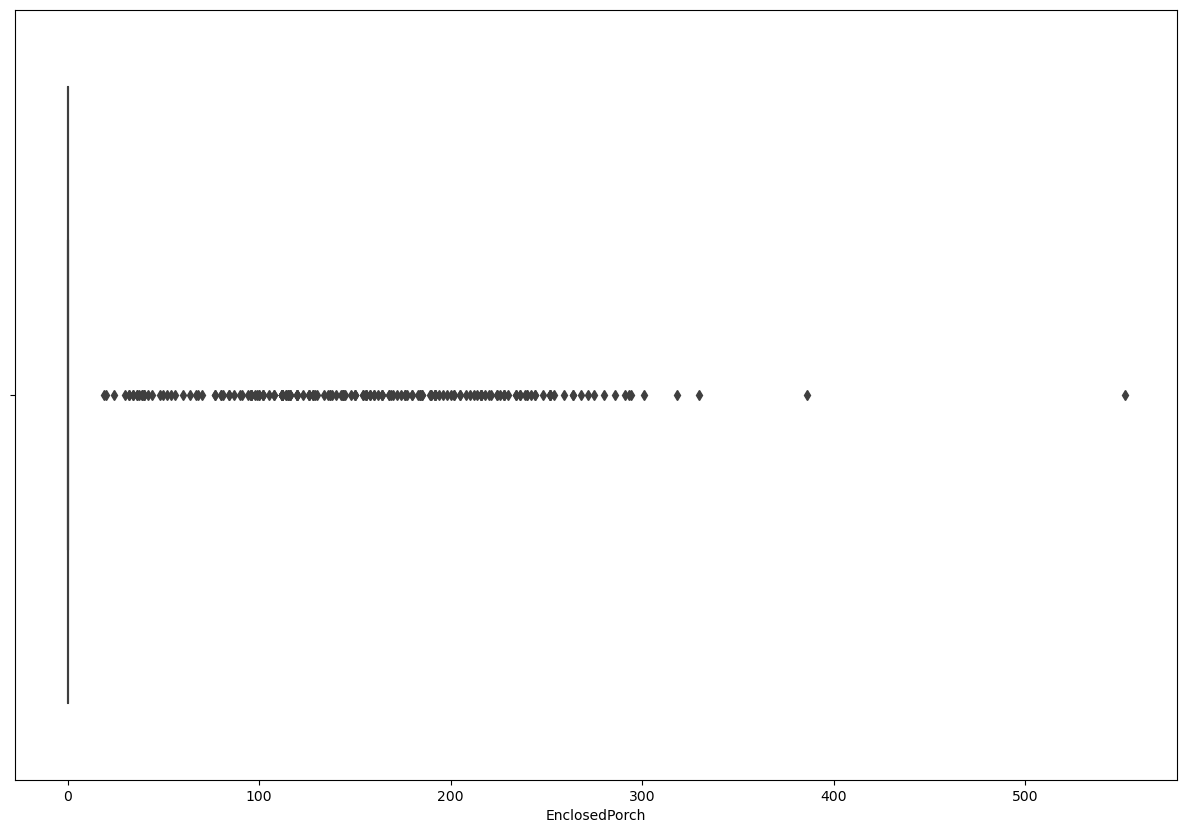

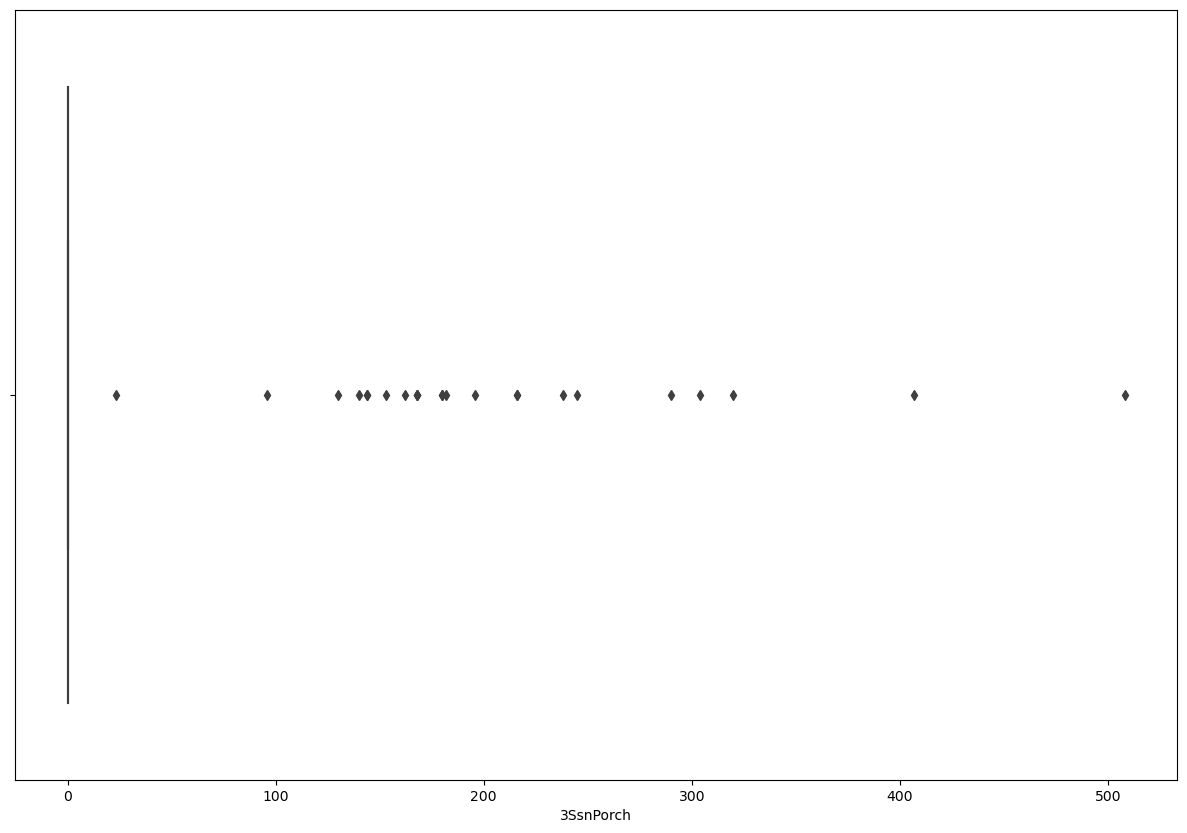

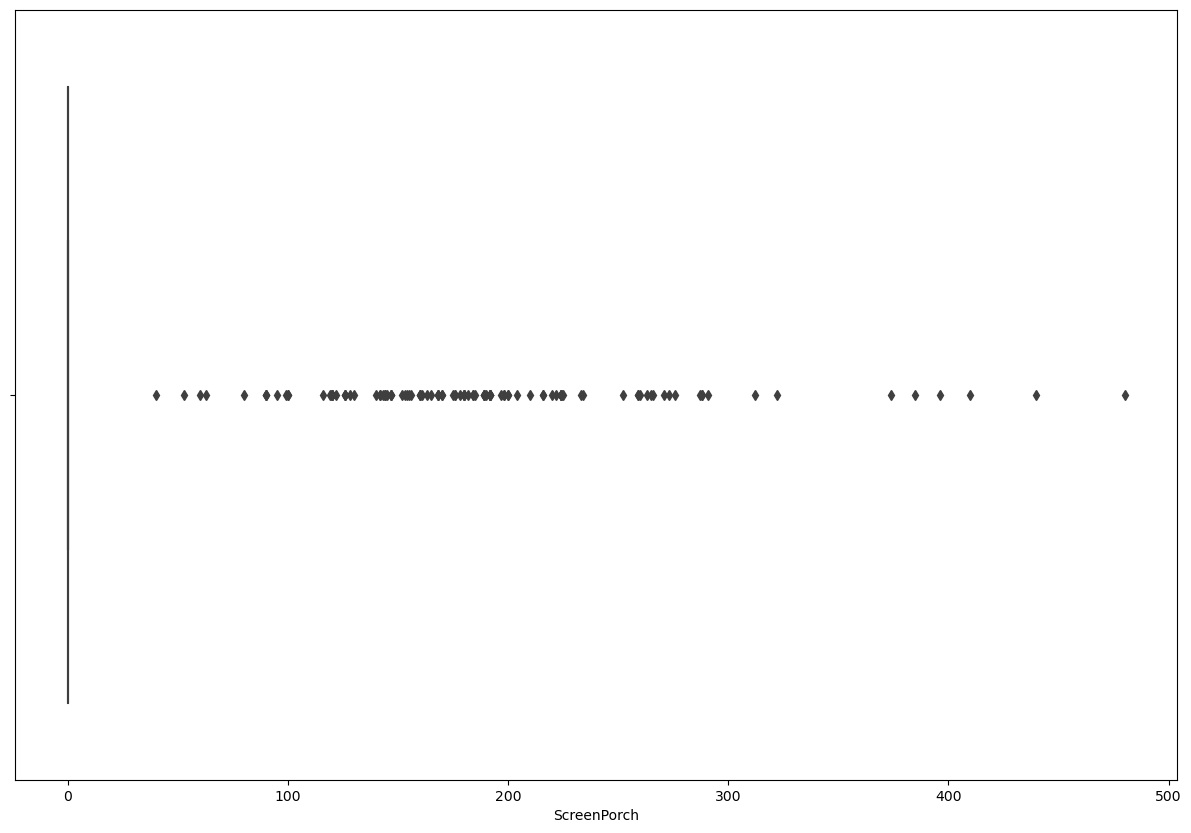

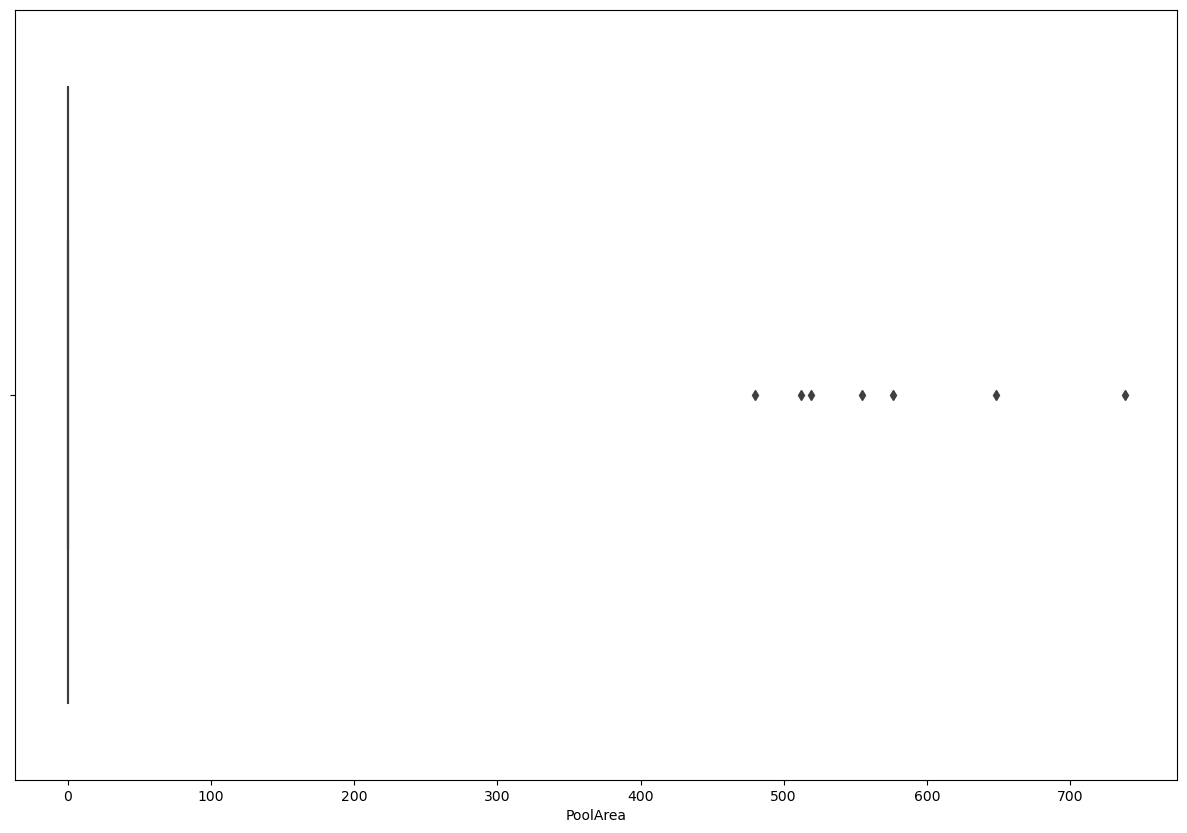

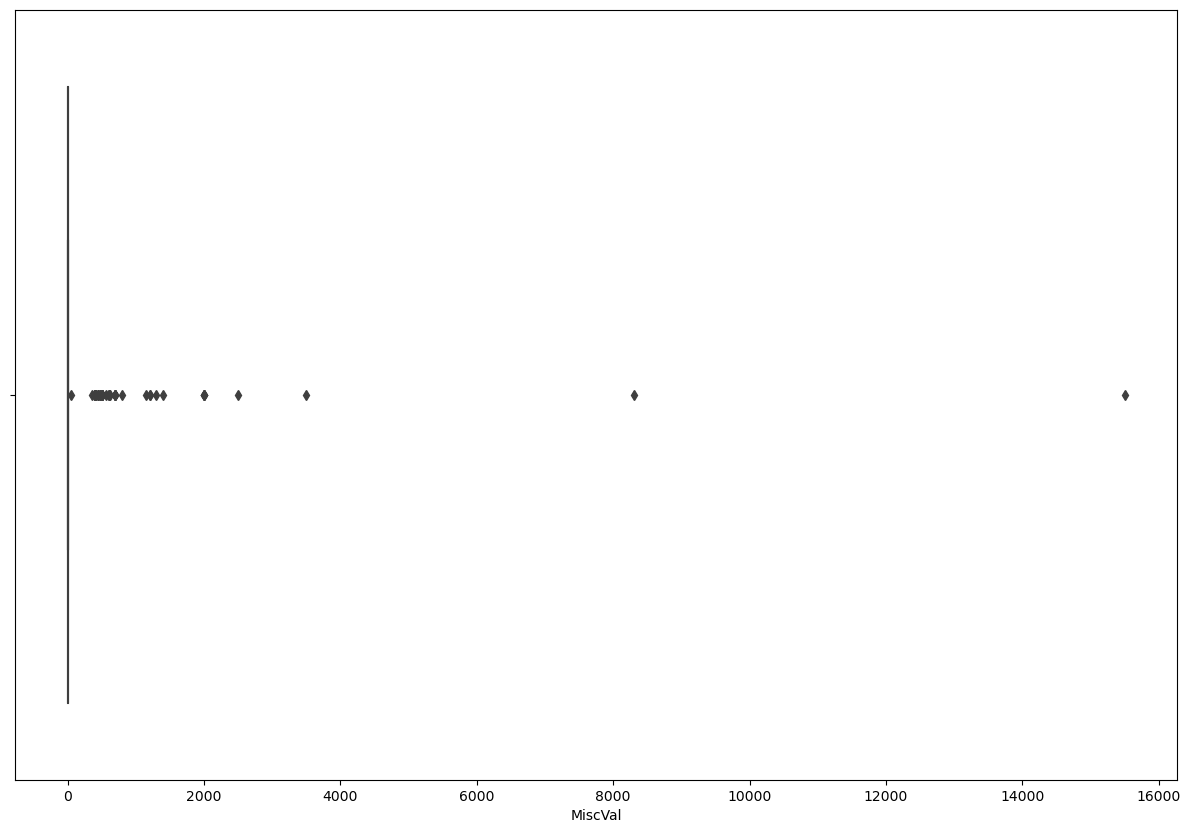

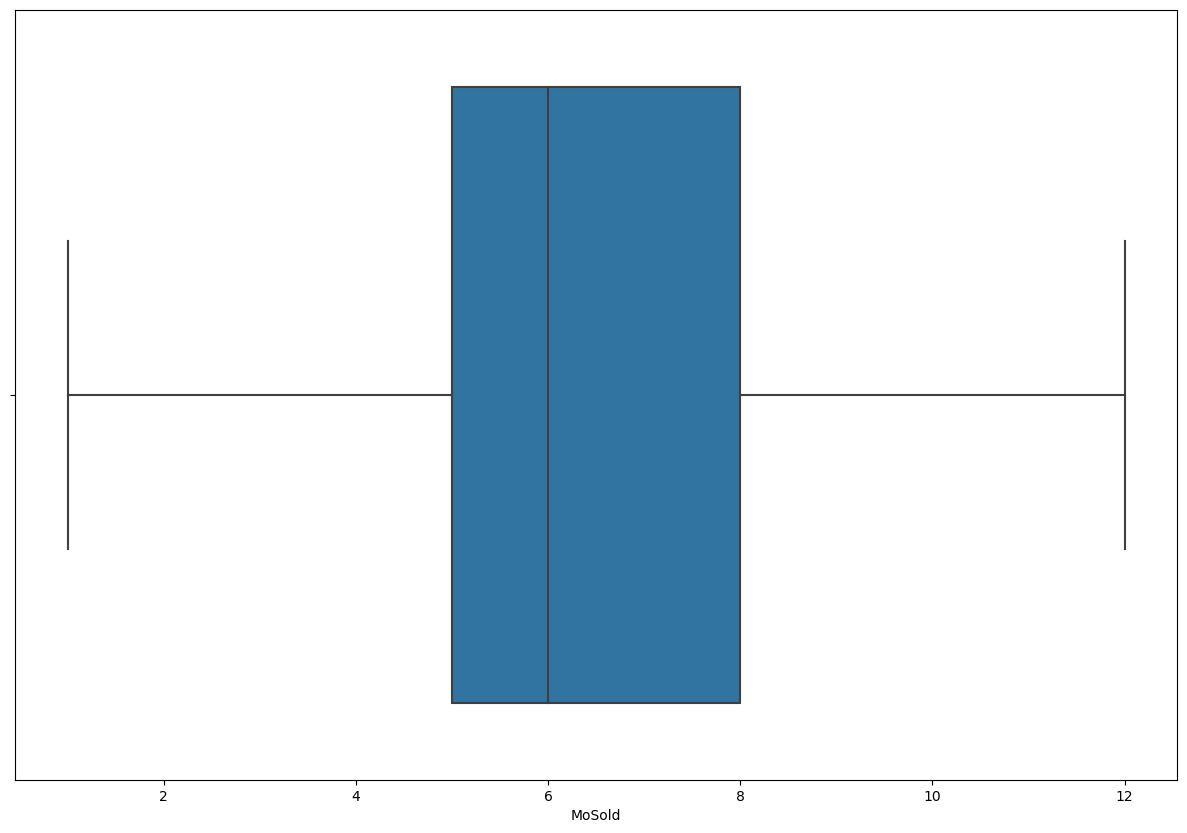

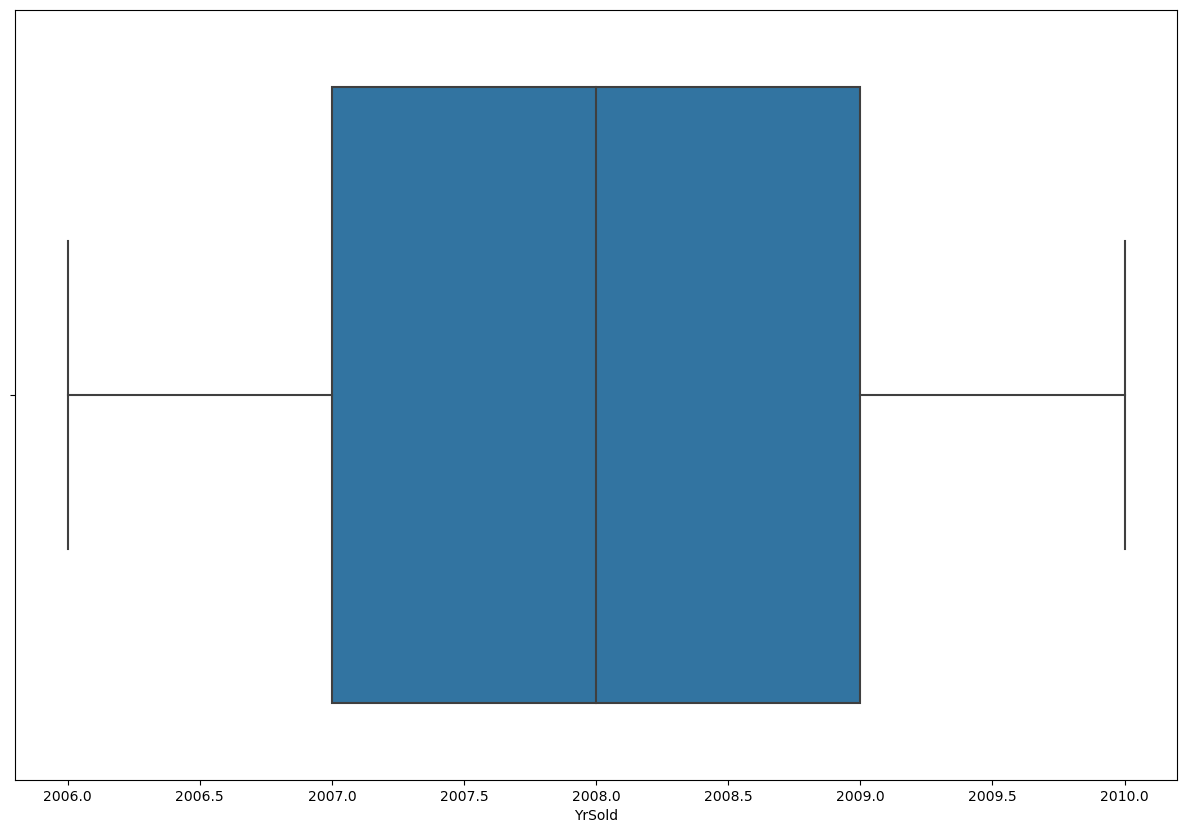

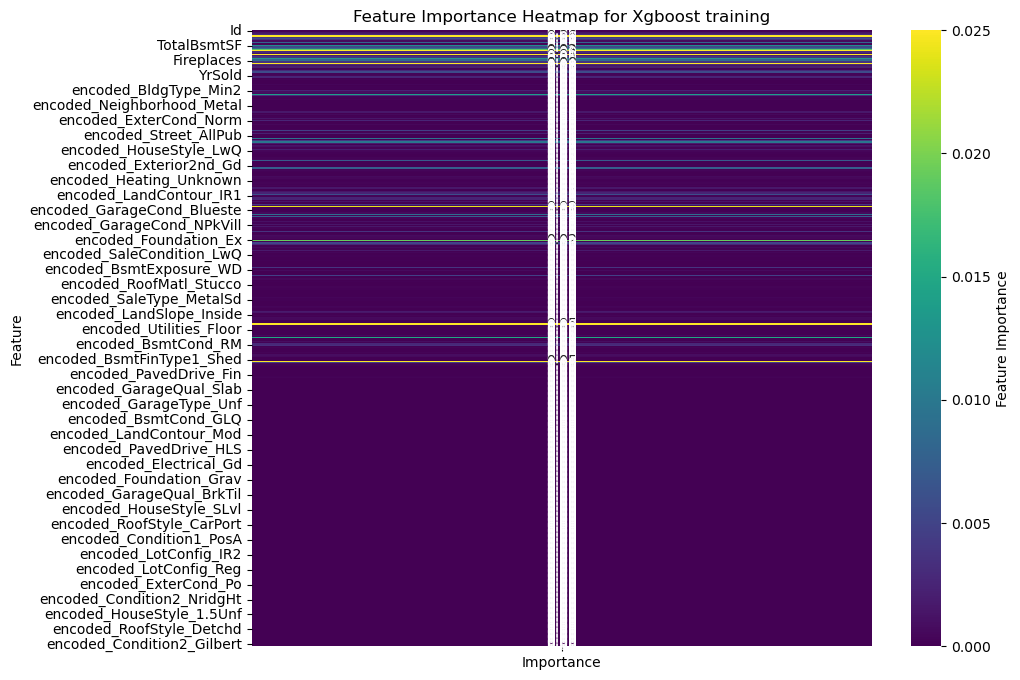

Top 10 feature in training: OverallQual, LowQualFinSF, GrLivArea, FullBath, GarageCars, encoded_HeatingQC_Detchd, encoded_Foundation_Ex, encoded_Exterior1st_Ex, encoded_MasVnrType_N, encoded_LotConfig_Bnk


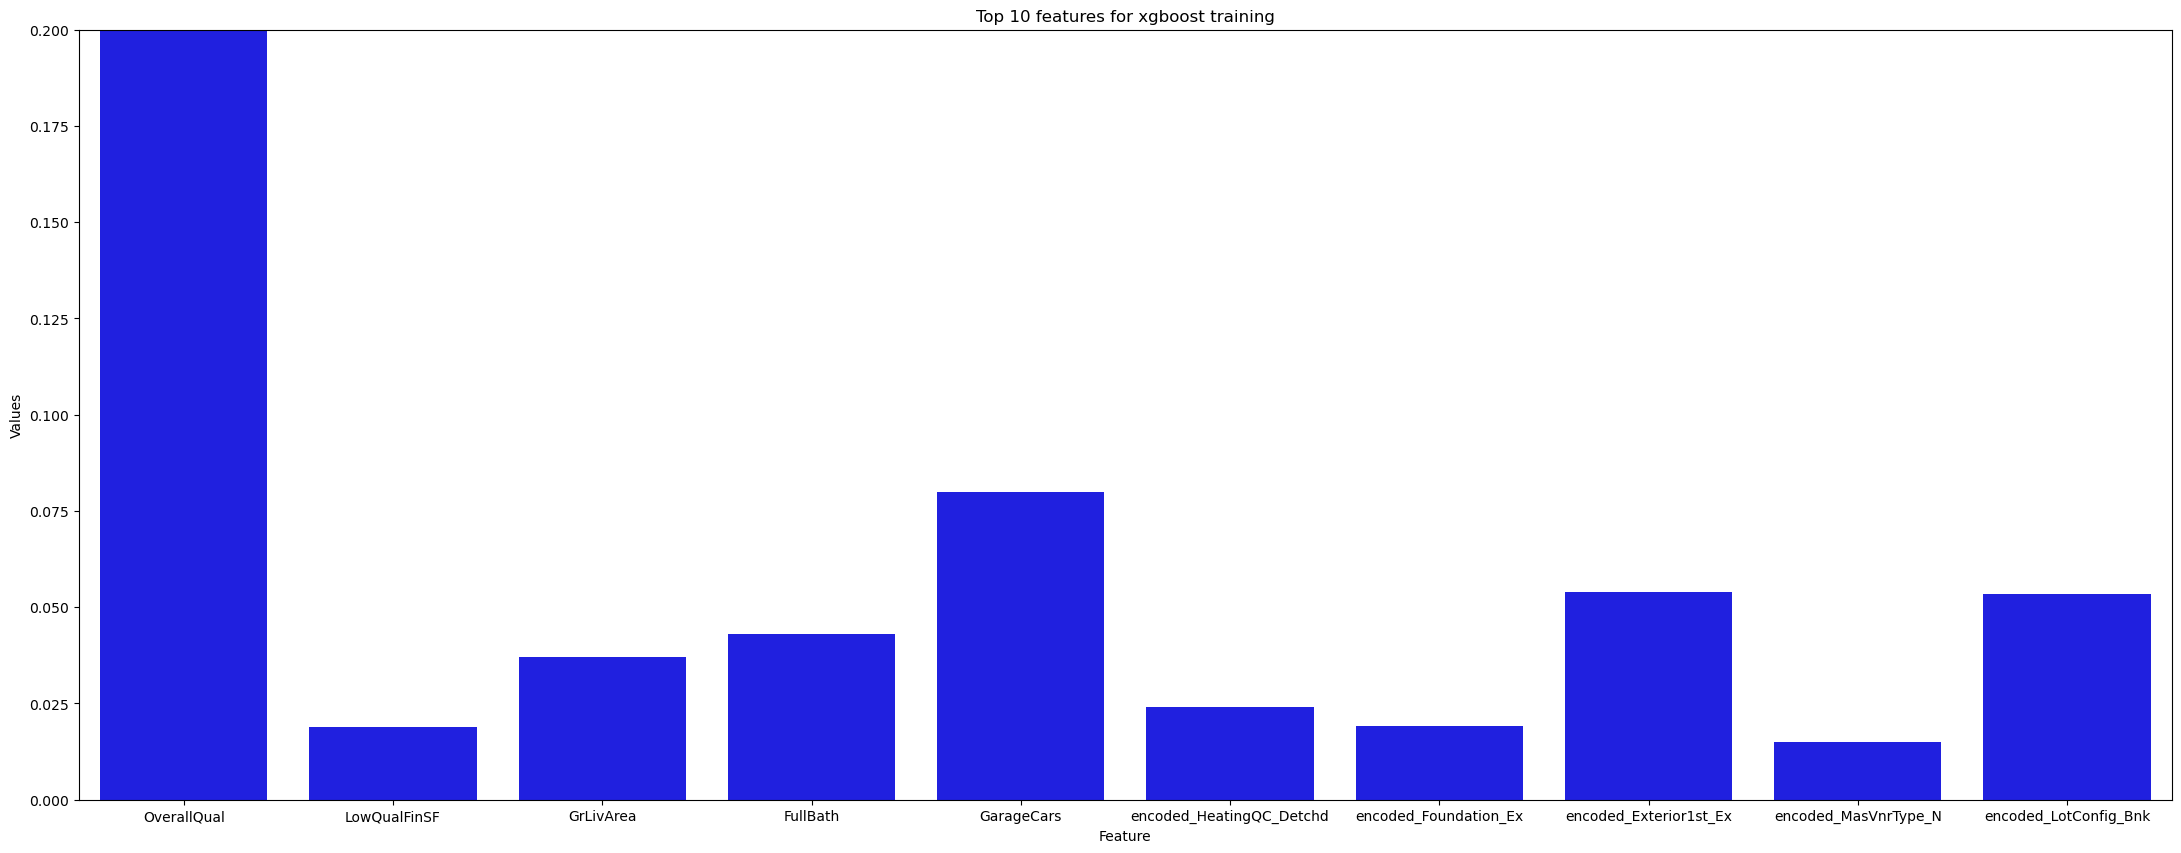

C:\Users\Sophie\Anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Text(0.5, 1.0, 'comparing the result of xgboost vs Random forest regressor')

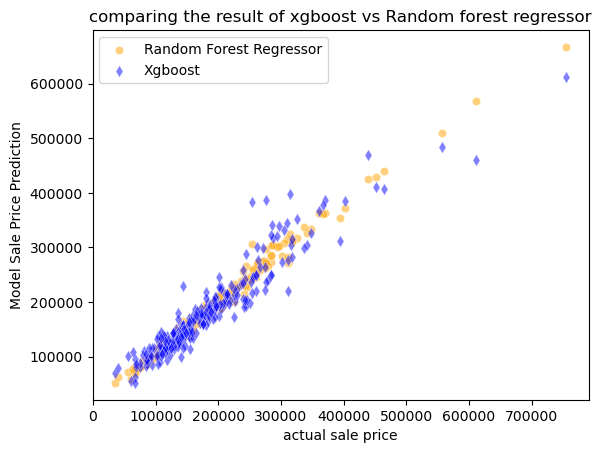

In [37]:
#Drop duplicate values
data.drop_duplicates(inplace=True)

##Handling missing data:
#first drop the columns with barely any value in it
data.drop(columns=['Alley','PoolQC','Fence','MiscFeature'],axis=1,inplace=True)
#start to fill in numerical columns with mean value; start to fill in categorical column with 'Unknown'  
null_columns=data.columns[data.isna().any()].tolist()
null_data=data[null_columns]

null_numeric_columns=null_data._get_numeric_data().columns
null_categorical_columns=list(set(null_columns)-set(null_numeric_columns))

#For numerical columns fill in the empty columns with mean values
for i in null_numeric_columns:
    data[i].fillna(data[i].mean(),inplace=True)
#For categorical columns fill in the empty columns with 'Unknown':
for i in null_categorical_columns:
    data[i].fillna('Unknown', inplace=True)


#To help visualize the outlier from each feature (numerical feature):
import matplotlib.pyplot as plt
df2=data.select_dtypes(exclude=['object'])
for column in df2:
        plt.figure(figsize=(15,10))
        sns.boxplot(data=df2, x=column,hue=column)
        
##Because there is a lot of outlier in our dataset-> we decide to do standardization for our columns features
all_columns=data.columns
numerical_columns=data._get_numeric_data().columns
categorical_columns=list(set(all_columns)-set(numerical_columns))

#Divide data set to data numerical and data categorical
data_numeric=data[numerical_columns]
data_object=data[categorical_columns]

##Convert year data 
Year_columns=[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']]

from datetime import datetime
current_year=datetime.now().year

for i in Year_columns:
    data_numeric[i]=current_year-data_numeric[i]


#Perform standardization:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
standarized_data=scaler.fit_transform(data_numeric)
standarized_data_numeric=pd.DataFrame(standarized_data,columns=data_numeric.columns)

#Perform one hot encoding for categorical_columns:
#data_object
string_to_add='encoded_'
pre_list={string_to_add+col for col in data_object.columns}
encoded_data_categorical=pd.get_dummies(data_object,columns=data_object.columns,prefix=pre_list)

#Merge two databases:
train_database=pd.concat([standarized_data_numeric,encoded_data_categorical],axis=1)

#encoded_data_object=pd.get_dummies(data_object,columns=data_object.columns,prefix=data_object)
#Import testing database and xgboost model to predict the house market 

import xgboost as xgb
from sklearn.metrics import mean_squared_error
##Use the same code as above to generate or prep your test database
test_database=pd.read_excel('converted_test_data.xlsx')

#Making sure the training and the testing datasets have similar features

#found in training set but not in the test set:
different_columns_train=list(set(train_database.columns)-set(test_database.columns))
##add columns to the test dataset
test_database[different_columns_train]=0

#found in the test set but not in training set:
different_columns_test=list(set(test_database.columns)-set(train_database.columns))
##add columns to the training dataset
train_database[different_columns_test]=0

##Rearrange columns in both columns
common_columns=train_database.columns.intersection(test_database.columns)

train_database=train_database[common_columns]
test_database=test_database[common_columns]

#Have to make sure both datasets have the same feature

#Create a xgboost regressor and make the prediction for the testing dataset
model=xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(train_database,data_y)
y_pred_xgboost=model.predict(test_database)

y_pred_xgboost=(pd.DataFrame(y_pred_xgboost)).values.flatten()
raw_test_database=pd.read_csv('test.csv')
raw_test_database['predicted SalePrice by xgboost model']=y_pred_xgboost

##The predicted SalePrice for the test dataset
#raw_test_database.to_csv('Final_outcome.csv')
##Evaluate the effectiveness of a xgboost model using mean squared error :
data_y=data_prep[['SalePrice']]
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(train_database, data_y, test_size=0.2, random_state=42)
model.fit(X_train,y_train)
y_pred_evaluation=model.predict(X_test)
y_pred_evaluation=(pd.DataFrame(y_pred_evaluation)).values.flatten()
y_test=(y_test.values.flatten())
y_pred_evaluation=y_pred_evaluation.astype(float)
y_test=y_test.astype(float)
mse = mean_squared_error(y_test, y_pred_evaluation)
print('Mean squared error:', mse)

comparison_table = pd.DataFrame({'database': y_test, 'Predicted result': y_pred_evaluation})
comparison_table.tail(50)

from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_evaluation)
print('R2 score for Xgboost training', r2)

# Identify which feature is important when training xgboostmodel
feature_importance = model.feature_importances_

# Create a DataFrame with feature names and importance values
feature_importance_df = pd.DataFrame({'Feature': train_database.columns, 'Importance': feature_importance})

vmin=0
vmax=0.025
plt.figure(figsize=(10, 8))
sns.heatmap(data=feature_importance_df.set_index('Feature'), annot=True, cmap='viridis', cbar_kws={'label': 'Feature Importance'}, fmt=".2f",vmin=vmin,vmax=vmax)
plt.title('Feature Importance Heatmap for Xgboost training')


plt.show()

my_list=feature_importance_df.loc[feature_importance_df['Importance']>0.014]['Feature'].to_list()
top10_feature=', '.join(my_list)
print('Top 10 feature in training:', top10_feature)

top10data=feature_importance_df[feature_importance_df['Feature'].isin (my_list)]
plt.figure(figsize=(27, 10))
sns.barplot(top10data,x='Feature',y='Importance',color='blue')
plt.title('Top 10 features for xgboost training')

plt.xlabel('Feature')
plt.ylabel('Values')
plt.ylim(0,0.2)
plt.show()

#Comparing the xgboost model with other model (in this case we use random forest regressor)
from sklearn.ensemble import RandomForestRegressor
# Create and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(train_database,data_y)

actual_sale_price=(pd.DataFrame(y_test)).values.flatten()
y_pred_xgboost=(pd.DataFrame(model.predict(X_test))).values.flatten()
y_pred_rregressor=(pd.DataFrame(rf_regressor.predict(X_test))).values.flatten()

sns.scatterplot(x=actual_sale_price, y=y_pred_rregressor, color='orange', marker='o', label='Random Forest Regressor',alpha=0.5)
sns.scatterplot(x=actual_sale_price, y=y_pred_xgboost, color='blue', marker='d', label='Xgboost',alpha=0.5)

# Add labels and a title
plt.xlabel('actual sale price')
plt.ylabel('Model Sale Price Prediction')
plt.title('comparing the result of xgboost vs Random forest regressor')
